EDA - Glovo Orders

-Clarice Mottet

Goal: forecast number of orders for every hour for a week ahead in BCN

Outline:
-Data Checks
-Distribution of order information
-Time dependence (trend, seasonality)
-Serial dependence (cycles)
-Stationarity

# Intelligent Data Development - Project 1
## Glovo Time Series Analysis

### by Natalia Bertrán, Clarice Mottet, Tatiana ----

0. **[Part 0: Set Up and Import](#part0)**
- **Objective**: Initialize programming environment.
- **Tasks:**
    - Library initialization
    - Import data into programming environment
    - Conduct missing data and duplication checks and correct accordingly

1. **[Part A.1: Model Creation](#partA1)**
- **Objective**: Create visualization for a reseach paper document storage structure in a graph framework
- **Tasks:**
  - Identify graph components

### Overview

**Part 0: Set Up and Import**
We found 19 hours - 3 days with some consecutative missing hours during the night where we had no order information. We added these hours/days into the data and filled in the order information in with a zero assuming that no orders were filled. This is a fine assumption as the time where the order information was missing were low order hours.


## <a id='part0'>Part 0: Set Up and Import</a>
- **Objective**: Initialize programming environment.
- **Tasks:**
    - Library initialization
    - Import data into programming environment
    - Conduct missing data and duplication checks and correct accordingly

- Library initialization

In [34]:
#libraries
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import numpy as np
from sklearn.metrics import mean_absolute_error
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from statsmodels.tsa.deterministic import DeterministicProcess
from scipy.signal import periodogram
from statsmodels.tsa.deterministic import Fourier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

XSMALL_SIZE = 8
SMALL_SIZE = 12
MEDIUM_SIZE = SMALL_SIZE + 3

plt.rc('font', size=XSMALL_SIZE)           # controls default text sizes\\n\",\n",
plt.rc('axes', titlesize=XSMALL_SIZE)     # fontsize of the axes title\\n\",\n",
plt.rc('axes', labelsize=XSMALL_SIZE)    # fontsize of the x and y labels\\n\",\n",
plt.rc('xtick', labelsize=XSMALL_SIZE)    # fontsize of the tick labels\\n\",\n",
plt.rc('ytick', labelsize=XSMALL_SIZE)    # fontsize of the tick labels\\n\",\n",
plt.rc('legend', fontsize=XSMALL_SIZE)    # legend fontsize\\n\",\n",
plt.rc('figure', titlesize=XSMALL_SIZE)  # fontsize of the figure title\\n\",\n",
plt.rc('figure', figsize=(7, 2))
plt.rc('figure', dpi=200)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

#paths
path_in_ = r'/home/clarice/Documents/VSCode/Term3/Intelligent_Data/IDD_glovo_time_series/inputs/'
path_out_ = r'/home/clarice/Documents/VSCode/Term3/Intelligent_Data/IDD_glovo_time_series/outputs/'


#global variables
TARGET = 'orders'

- Import data into programming environment

In [2]:
#import data into python

df_orders = pd.read_csv(path_in_ + 'data_BCN.csv', dtype = str)
df_orders['time'] = pd.to_datetime(df_orders['time'])
df_orders['orders'] = pd.to_numeric(df_orders['orders'])

df_orders.sort_values(by = ['time'], inplace = True)
df_orders.reset_index(drop = True, inplace = True)

#val dataset is last month of data
df_val = df_orders[df_orders['time']>=pd.to_datetime('2022-01-01')].copy()
df_orders = df_orders[df_orders['time']<pd.to_datetime('2022-01-01')]

In [79]:
df_orders.head()

,time,orders,city
0,2021-02-01 00:00:00,0.0,BCN
1,2021-02-01 01:00:00,0.0,BCN
2,2021-02-01 02:00:00,0.0,BCN
3,2021-02-01 03:00:00,0.0,BCN
4,2021-02-01 04:00:00,0.0,BCN


- Conduct missing data and duplication checks and correct accordingly

In [122]:
#basic stats - time

df_orders[['time']].describe().T

,count,mean,min,25%,50%,75%,max
time,7998,2021-07-18 01:19:46.946736896,2021-02-01 00:00:00,2021-04-25 13:15:00,2021-07-18 02:30:00,2021-10-09 09:45:00,2021-12-31 23:00:00


Start Time: 2021-02-01
  End Time: 2022-02-01

Data appears to be on hourly level.

In [3]:
#data checks - null, duplicates, missing?

#are there any orders with null information?
print("number of null orders:",df_orders['orders'].isna().sum())

#do we have duplicate order information?
df_view = df_orders.copy()
df_view.drop_duplicates(subset = ['time'], inplace = True)
print("import row count:", len(df_orders['time']))
print("post dup rmv row count:", len(df_view['time']))
del df_view

#are we missing any minute by minute order information?
start_time = pd.to_datetime('2021-02-01')
end_time = pd.to_datetime('2022-01-01')
date_range = pd.date_range(start=start_time, end=end_time, freq='h')
df_all = pd.DataFrame(date_range, columns=['time_all'])
df_all = df_all[df_all['time_all']<end_time]

df_all = df_all.merge(df_orders[['time']], how = 'left', left_on = ['time_all'], right_on = ['time'])
print("number of hours missing:",df_all['time'].isna().sum())
df_all_msng = df_all[df_all['time'].isna()].copy()
print("hours missing order information:")
print(df_all_msng)


number of null orders: 0
import row count: 7998
post dup rmv row count: 7998
number of hours missing: 18
hours missing order information:
                time_all time
336  2021-02-15 00:00:00  NaT
337  2021-02-15 01:00:00  NaT
338  2021-02-15 02:00:00  NaT
339  2021-02-15 03:00:00  NaT
340  2021-02-15 04:00:00  NaT
341  2021-02-15 05:00:00  NaT
3024 2021-06-07 00:00:00  NaT
3025 2021-06-07 01:00:00  NaT
3026 2021-06-07 02:00:00  NaT
3027 2021-06-07 03:00:00  NaT
3028 2021-06-07 04:00:00  NaT
3029 2021-06-07 05:00:00  NaT
6216 2021-10-18 00:00:00  NaT
6217 2021-10-18 01:00:00  NaT
6218 2021-10-18 02:00:00  NaT
6219 2021-10-18 03:00:00  NaT
6220 2021-10-18 04:00:00  NaT
6221 2021-10-18 05:00:00  NaT


There are 19 hours where we are missing order information taking place over 4 days for multiple consecutive hours.

Just as a placeholder, I'm going to use the average order information but only for data before the point where there is a null value

In [4]:
#add in the hours that the orders data frame is currently missing

#add in the missing hours
df_orders = df_all[['time_all']].merge(df_orders, how = 'left', left_on = ['time_all'], right_on = ['time'])
df_orders.sort_values(by = ['time_all'], inplace = True)

#set missing hour order count to zero
df_orders.loc[df_orders['orders'].isna(), 'orders'] = 0

print("number of nulls",df_orders['orders'].isna().sum())

df_orders_msng = df_orders[df_orders['time'].isna()].copy()
print(df_orders_msng)

df_orders.loc[df_orders['time'].isna(), 'time'] = df_orders['time_all']
df_orders.sort_values(by = ['time_all'], inplace = True)
df_orders.reset_index(drop = True, inplace = True)
df_orders = df_orders[['time', 'orders', 'city']]

number of nulls 0
                time_all time  orders city
336  2021-02-15 00:00:00  NaT     0.0  NaN
337  2021-02-15 01:00:00  NaT     0.0  NaN
338  2021-02-15 02:00:00  NaT     0.0  NaN
339  2021-02-15 03:00:00  NaT     0.0  NaN
340  2021-02-15 04:00:00  NaT     0.0  NaN
341  2021-02-15 05:00:00  NaT     0.0  NaN
3024 2021-06-07 00:00:00  NaT     0.0  NaN
3025 2021-06-07 01:00:00  NaT     0.0  NaN
3026 2021-06-07 02:00:00  NaT     0.0  NaN
3027 2021-06-07 03:00:00  NaT     0.0  NaN
3028 2021-06-07 04:00:00  NaT     0.0  NaN
3029 2021-06-07 05:00:00  NaT     0.0  NaN
6216 2021-10-18 00:00:00  NaT     0.0  NaN
6217 2021-10-18 01:00:00  NaT     0.0  NaN
6218 2021-10-18 02:00:00  NaT     0.0  NaN
6219 2021-10-18 03:00:00  NaT     0.0  NaN
6220 2021-10-18 04:00:00  NaT     0.0  NaN
6221 2021-10-18 05:00:00  NaT     0.0  NaN


In [5]:
#extract out features from time field (hour, day, month, year)

df_orders['year'] = df_orders['time'].dt.year
df_orders['month'] = df_orders['time'].dt.month
df_orders['day'] = df_orders['time'].dt.day
df_orders['hour'] = df_orders['time'].dt.hour
df_orders['date'] = pd.to_datetime(df_orders[['year','month','day']])
df_orders['dayofweek'] = df_orders['time'].dt.day_of_week
df_orders['dayofyear'] = df_orders['time'].dt.day_of_year

df_orders.sort_values(by = ['time'], inplace = True)
df_orders.reset_index(drop = True, inplace = True)

df_orders['time_index'] = 1
df_orders['time_index'] = df_orders['time_index'].cumsum()


## Distribution of Order Information

The median is 30 and the mean is 72.99 so the data is extremely right skewed.

When hour blocks with zero orders are removed the median is 61 and the mean is 107.08 so still very right skewed.

Once there are more than 70-ish orders occurring, the difference between the median and mean grows.


In [126]:
#general statistics

df_orders[[TARGET]].describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
orders,7993.0,70.94,107.52,0.0,0.0,29.0,93.1,939.0


array([[<AxesSubplot:title={'center':'orders'}>]], dtype=object)

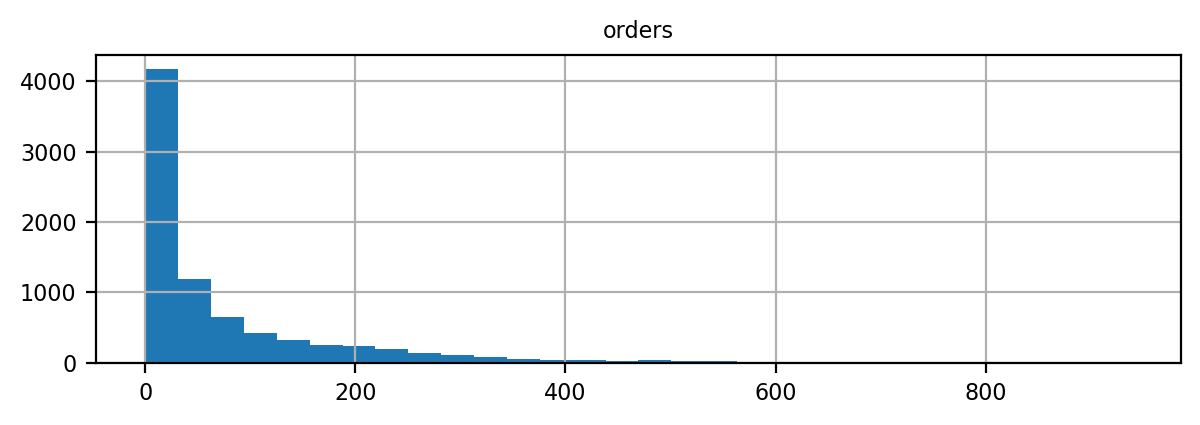

In [127]:
df_orders[[TARGET]].hist(bins=30)

- Remove orders that are zero and evaluate

In [128]:
df_view = df_orders[df_orders['orders']>0]
df_view[[TARGET]].describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
orders,5450.0,104.05,116.23,0.7,28.0,59.5,148.0,939.0


array([[<AxesSubplot:title={'center':'orders'}>]], dtype=object)

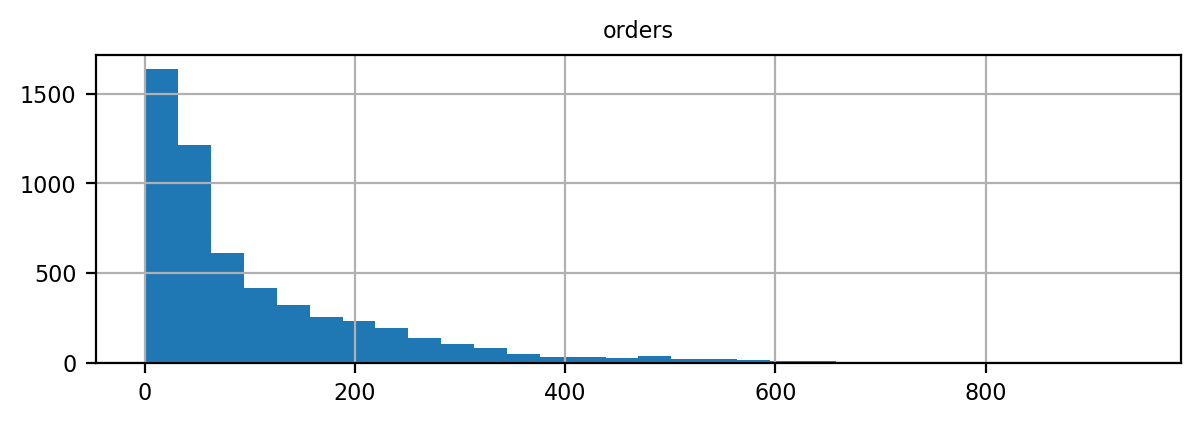

In [129]:
df_view[[TARGET]].hist(bins=30)

- What range of order amounts gives and equal-ish mean and median

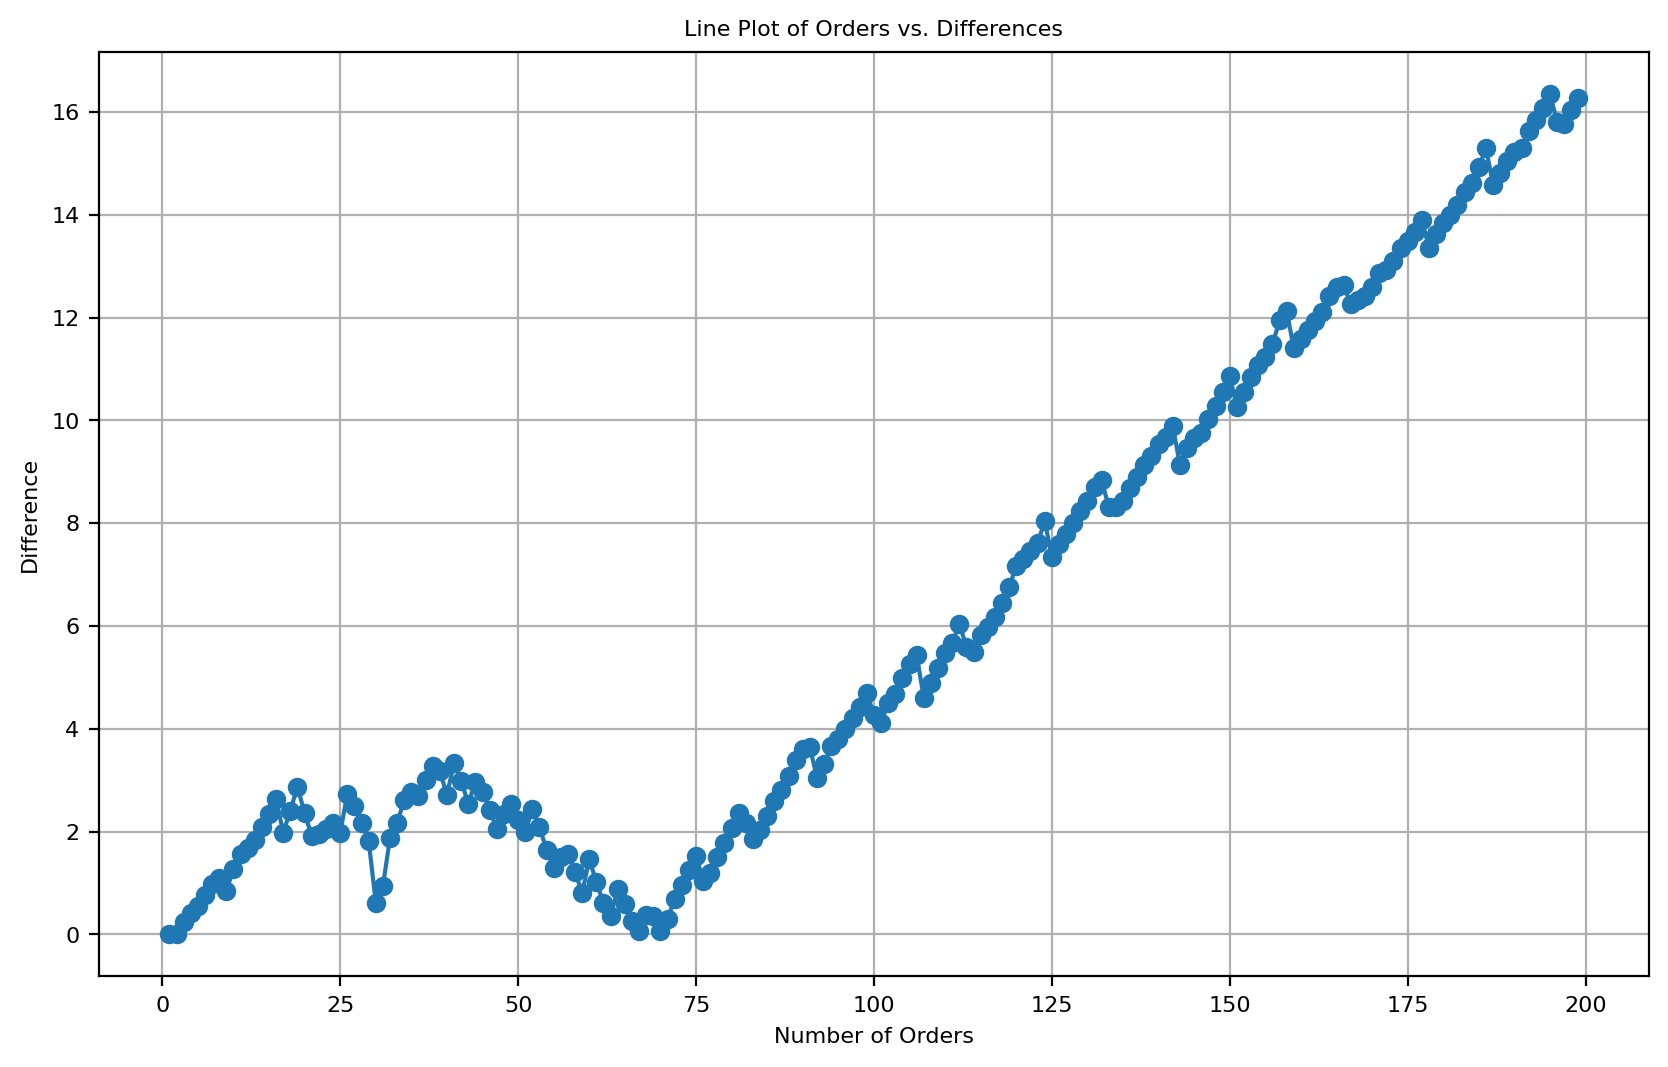

In [6]:
df_view = df_orders[df_orders['orders']>0]

list_ = []

for n_orders in range(1,200):
    df_subset = df_view[df_view['orders']<n_orders]
    mean_ = df_subset['orders'].mean()
    median_ = df_subset['orders'].median()
    diff_ = abs(mean_ - median_)
    dict_ = {'n_orders':n_orders, 'mean':mean_, 'median':median_, 'diff':diff_}
    df_ = pd.DataFrame(dict_, index = [0])
    list_.append(df_)

#plot the n_orders against the difference of the mean and median
df_diff = pd.concat(list_, ignore_index = True)
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_diff['n_orders'].values, df_diff['diff'].values, marker='o')  # Line plot with markers
plt.title('Line Plot of Orders vs. Differences')  # Title of the plot
plt.xlabel('Number of Orders')  # X-axis label
plt.ylabel('Difference')  # Y-axis label
plt.grid(True)  # Add grid for better readability
plt.show()


In [131]:
df_view = df_orders[df_orders['orders']>0]
df_view = df_view[df_view['orders']<=70]
print(len(df_orders[TARGET]))
df_view[[TARGET]].describe().round(2).T


7993


,count,mean,std,min,25%,50%,75%,max
orders,3022.0,30.26,19.9,0.7,14.0,30.0,45.0,70.0


array([[<AxesSubplot:title={'center':'orders'}>]], dtype=object)

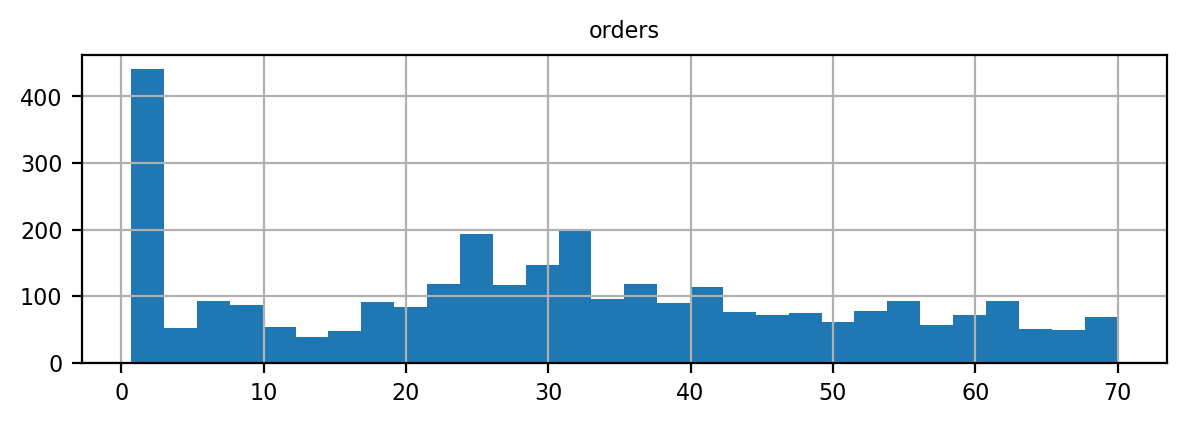

In [132]:
df_view[[TARGET]].hist(bins=30)

In [133]:
df_view = df_orders[df_orders['orders']>0]
df_view = df_view[df_view['orders']>400]
print(len(df_orders[TARGET]))
df_view[[TARGET]].describe().round(2).T


7993


,count,mean,std,min,25%,50%,75%,max
orders,178.0,515.58,92.02,401.0,447.5,490.5,560.75,939.0


[Text(0.5, 1.0, 'time vs target'), Text(0, 0.5, 'target')]

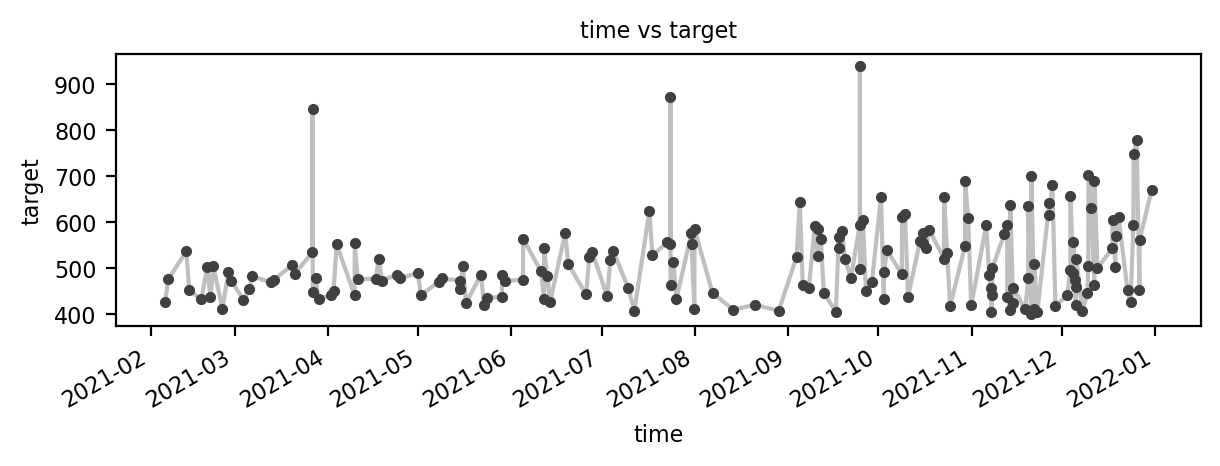

In [134]:
x_val = 'time'
y_val = TARGET

ax = df_view.plot(x = x_val, y = y_val, **plot_params)
ax.set(title = x_val+' vs target', ylabel = 'target')

There's a lot of skew-ness that I'm not sure how to properly account for so going to pause on it for now. 

### Trends?

- Create a LR for orders based on time-index to evaluate mean related trend
- Calculate rolling mean for different window and window sizes and look at mean, median, std

The rate of change for the LR was .0035 (not the strongest trend increase)

In [7]:
#LR - time index

X = df_orders[['time_index','time']]
X.set_index('time',inplace = True)
y = df_orders[[TARGET]]  # the target

model = LinearRegression()
model.fit(X, y)

#possible there is a slight trend (1.3% increase)
print(model.coef_)
print(model.intercept_)

y_pred = pd.Series(model.predict(X).flatten(), index=X.index)

[[0.00362549]]
[56.57584211]


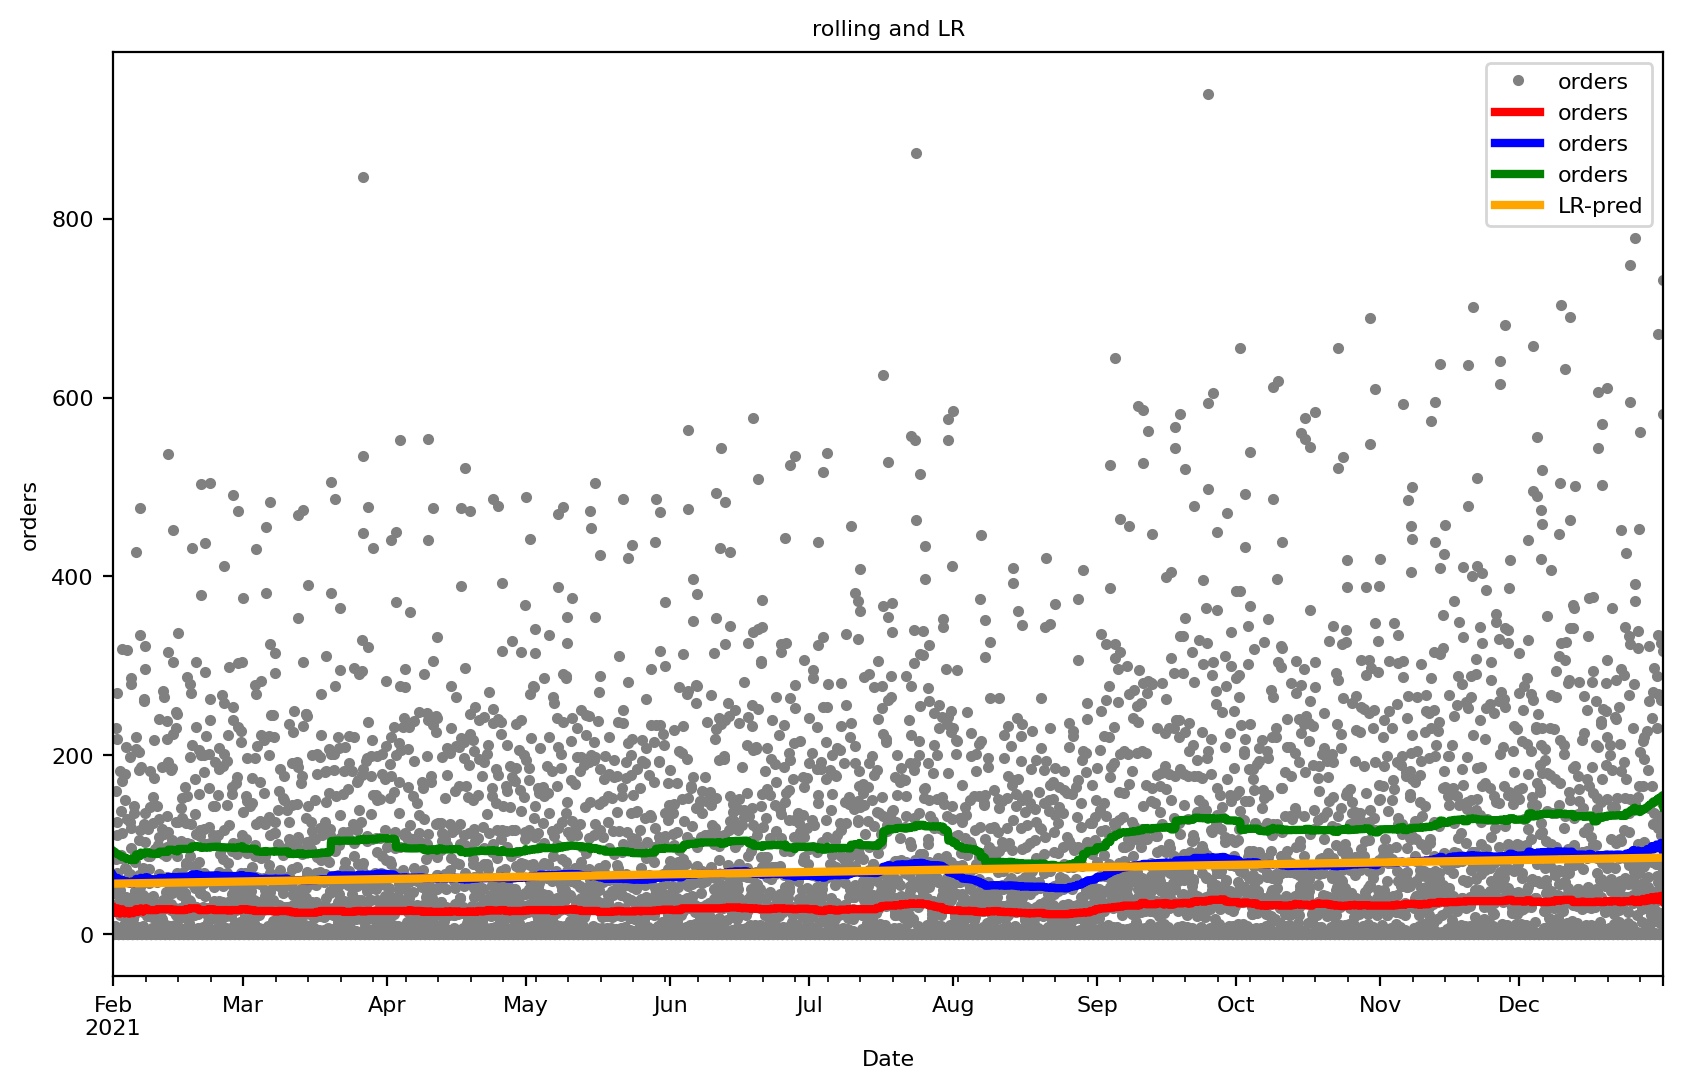

In [8]:
#look for potential trend

df_orders_time = df_orders.set_index('time')
rolling_window = df_orders_time[[TARGET]].rolling(
    window=336,       # two weeks
    center=True,       # places the window's center at each point
    min_periods=168,   # 168 = 24*7 (one week)
)

moving_median = rolling_window.median()  # Compute the median
moving_mean = rolling_window.mean()      # Compute the mean
moving_std = rolling_window.std()      # Compute the mean

# Plotting
ax = df_orders_time[[TARGET]].plot(style=".", color="0.5", figsize=(10, 6))
moving_median.plot(ax=ax, linewidth=3, color='red', legend=True, label='Rolling Median')
moving_mean.plot(ax=ax, linewidth=3, color='blue', legend=True, label='Rolling Mean')
moving_std.plot(ax=ax, linewidth=3, color='green', legend=True, label='Rolling STD')
y_pred.plot(ax=ax, linewidth=3, color='orange', legend=True, label='LR-pred')
ax.set_title("rolling and LR")
ax.set_xlabel("Date")  # Assuming the index of df_orders_time is some datetime type
ax.set_ylabel(TARGET)

plt.show()


### Seasonality?

- Hour of Day:
    - Day of Week - seasonality
    - Periodgram
- Day within month
- Month within year

- Hour of Day: Seasonality

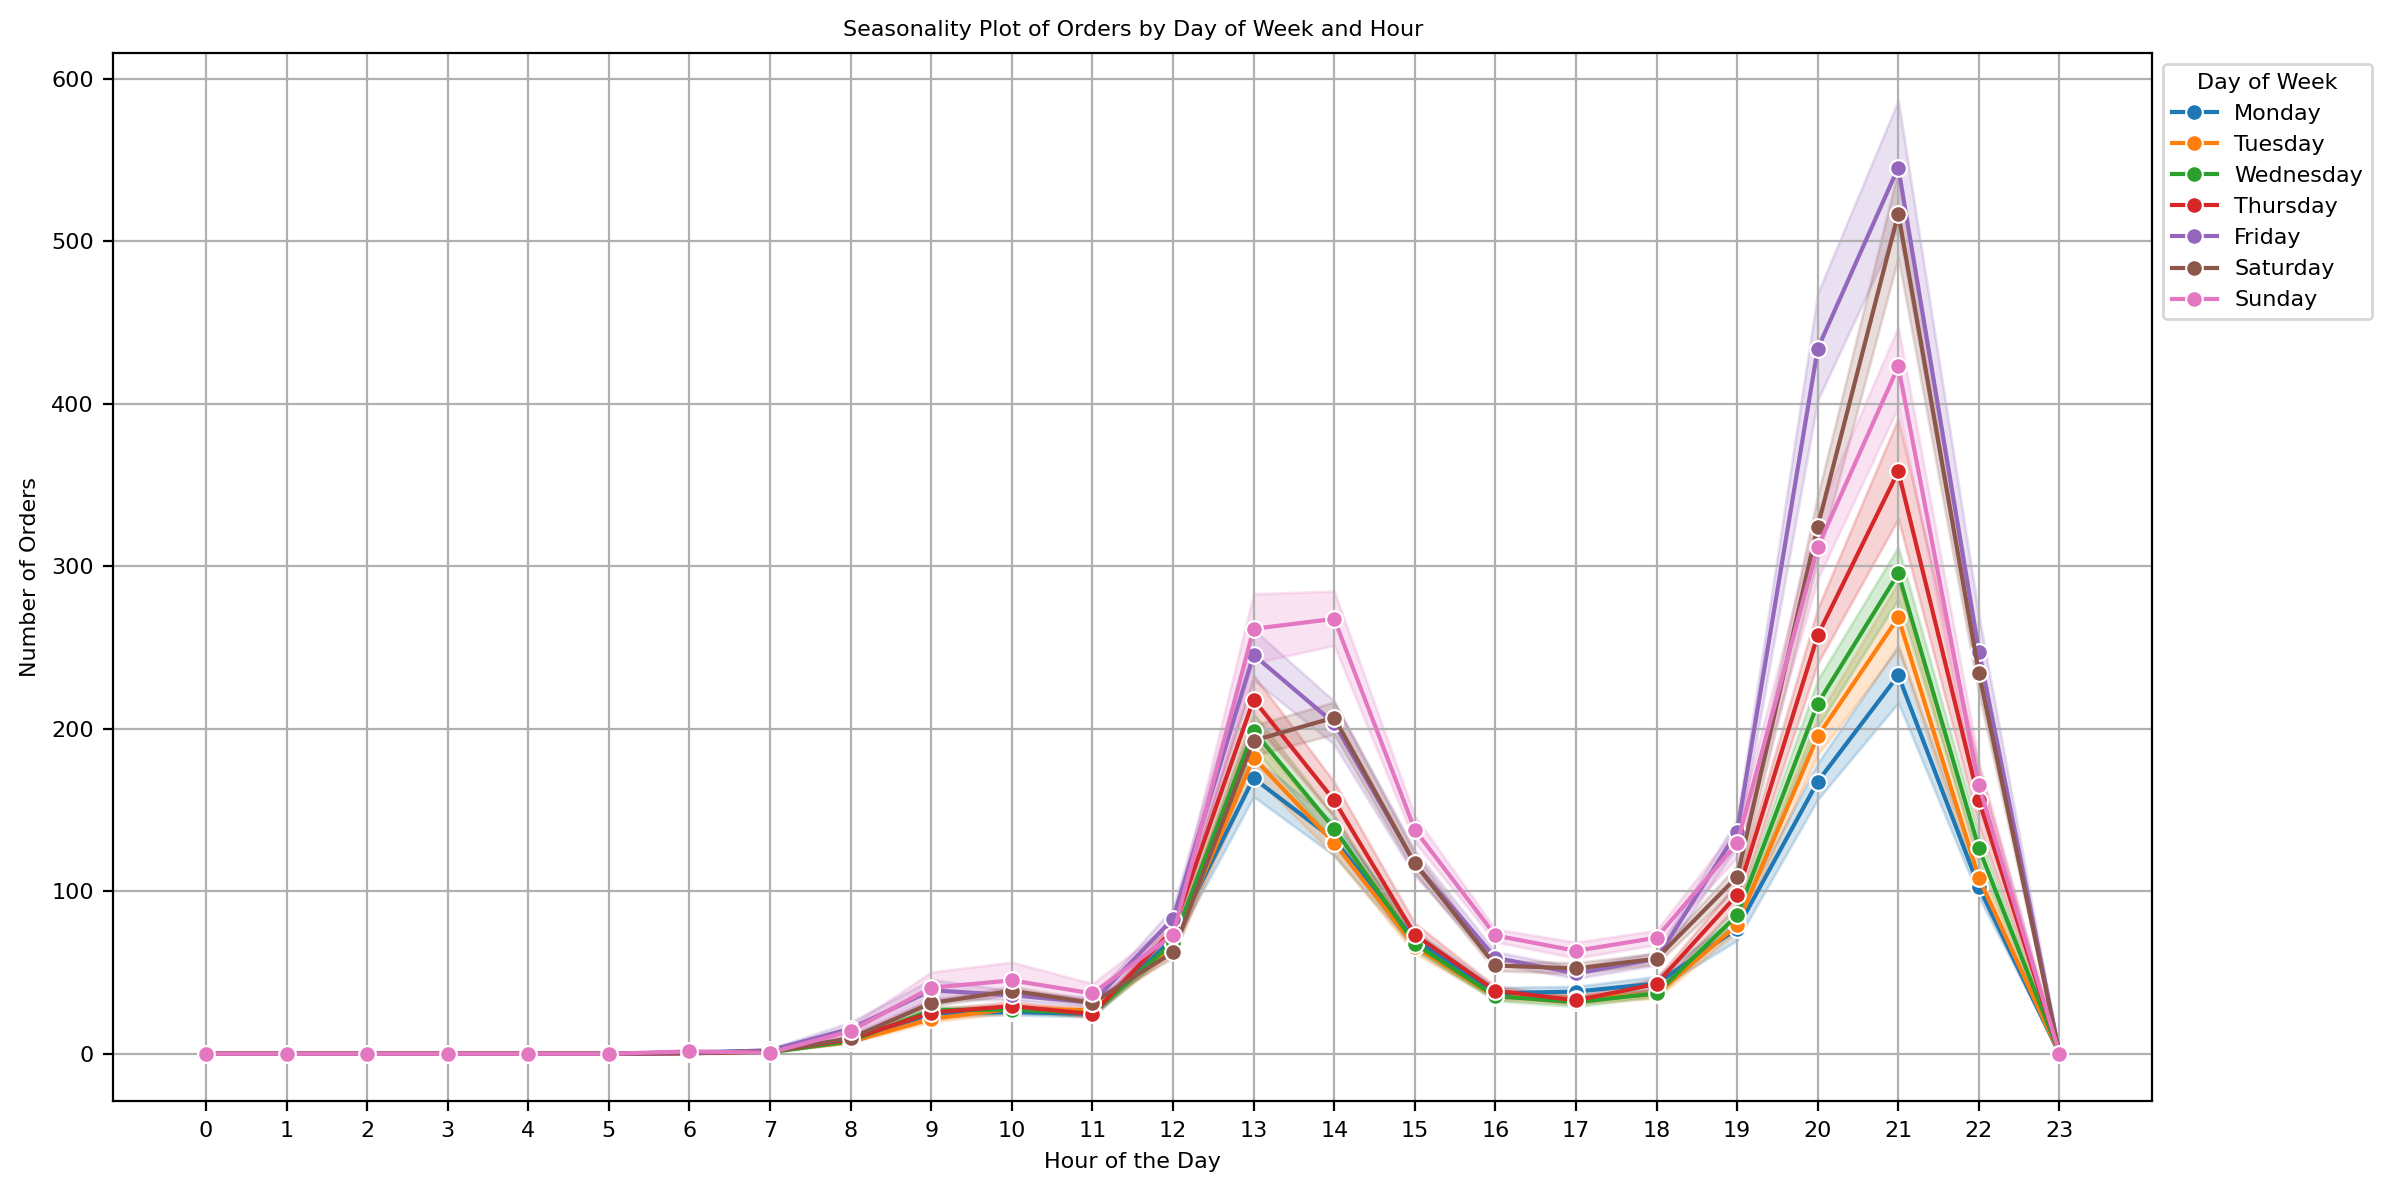

In [7]:
#line plot - hour level by day of week

# Extract day of week and hour from the 'time' column
df_orders['dayofweek'] = df_orders['time'].dt.day_name()
df_orders['hour'] = df_orders['time'].dt.hour

# Create a seasonal plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_orders, x='hour', y='orders', hue='dayofweek', marker='o')

plt.title('Seasonality Plot of Orders by Day of Week and Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.xticks(range(24))  # Set x-axis ticks to show every hour
plt.legend(title='Day of Week', loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside the plot
plt.tight_layout()
plt.show()


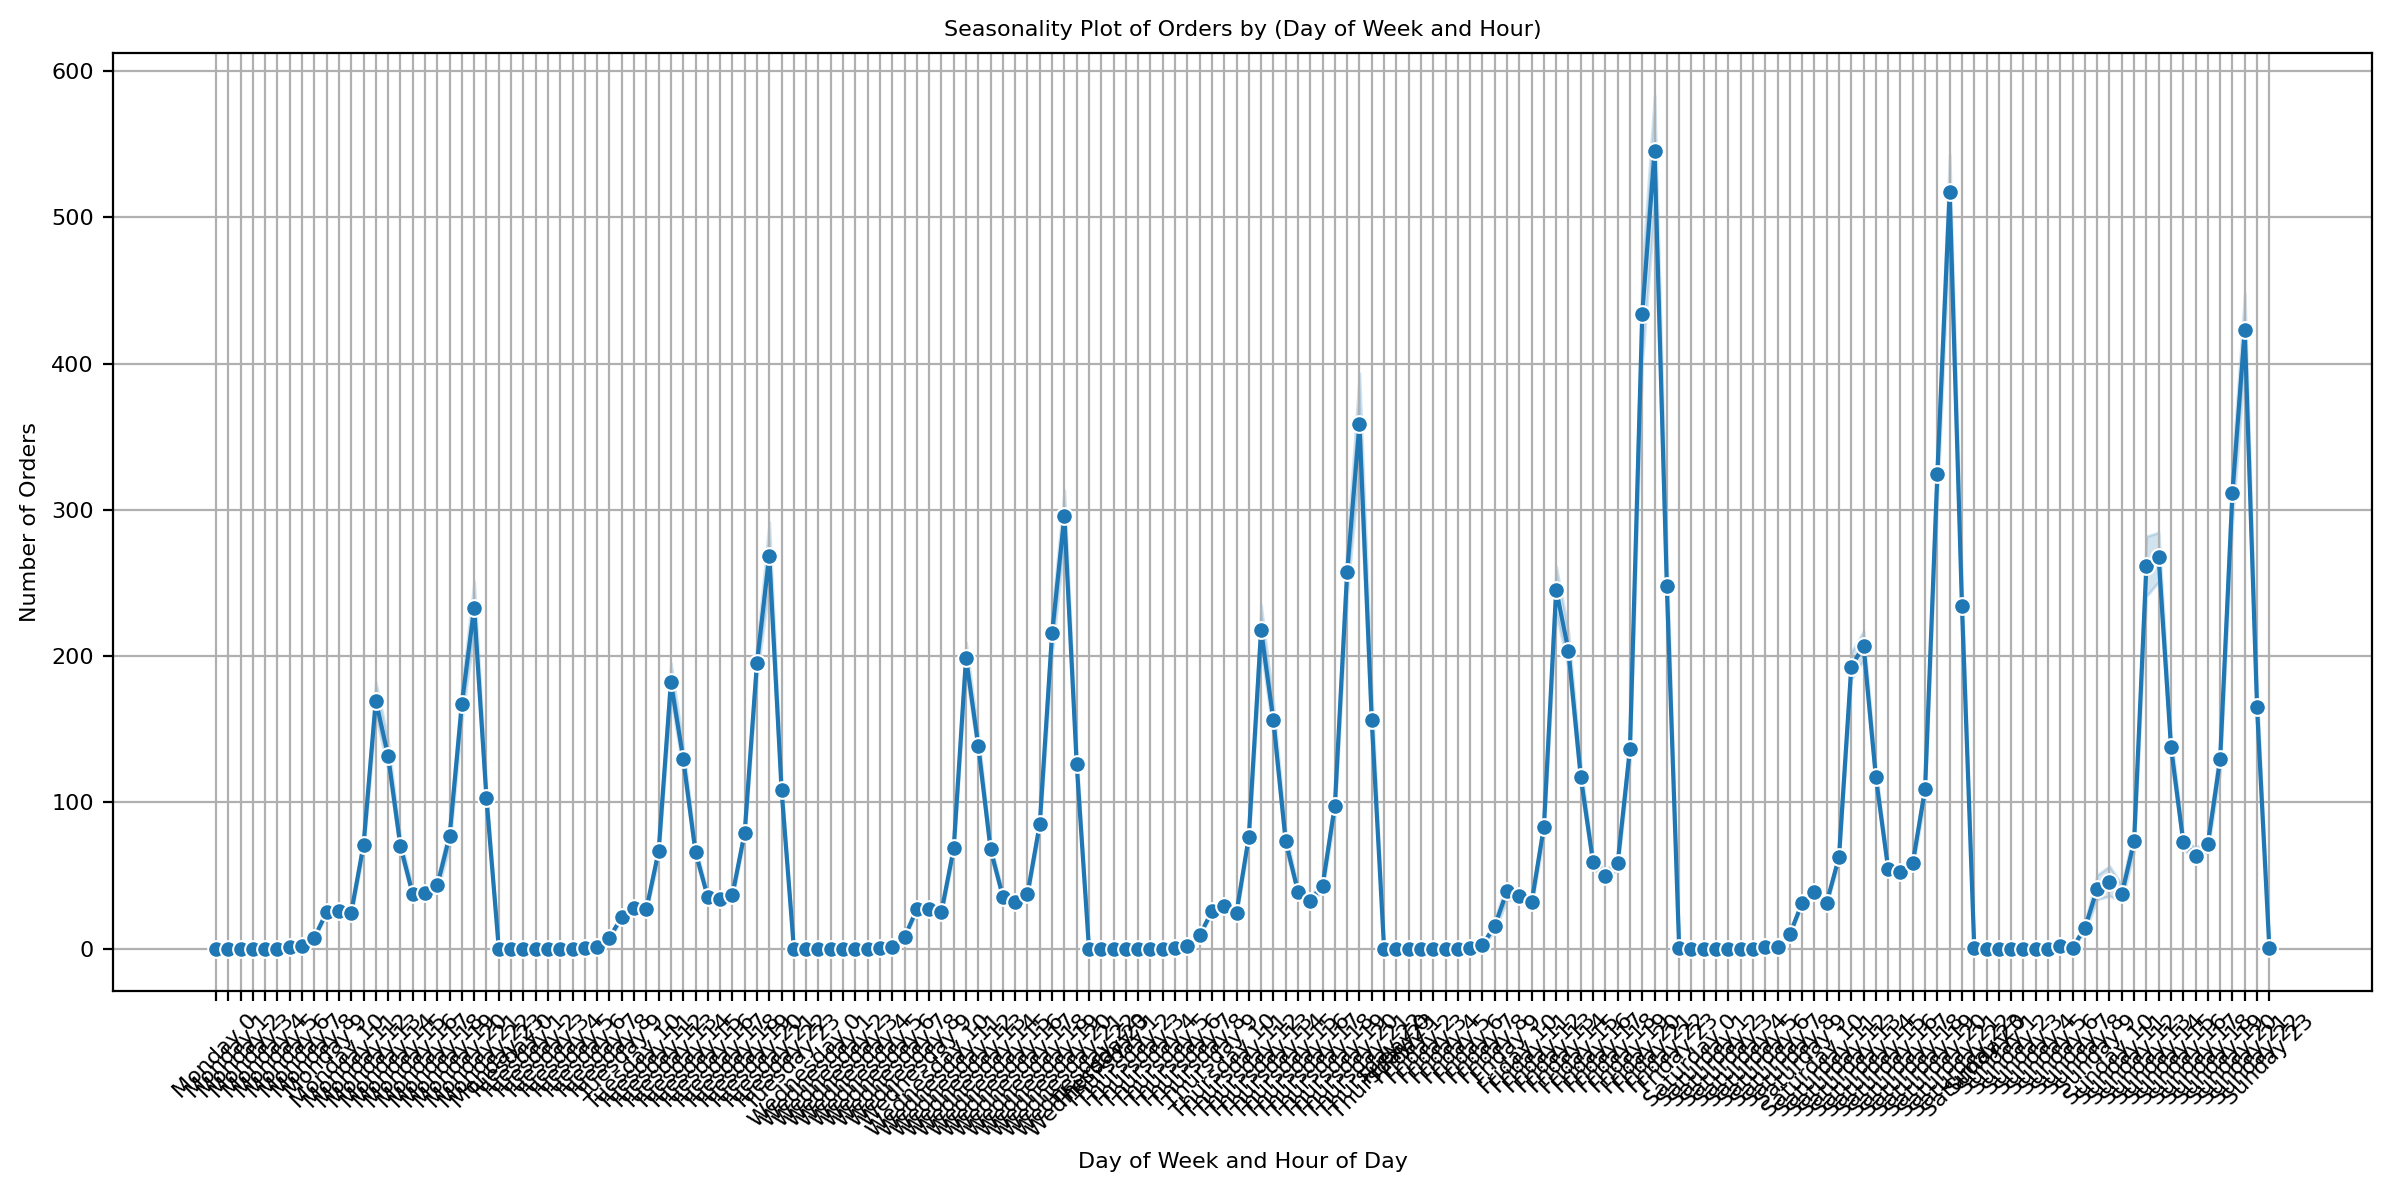

In [8]:
#single line plot - hour of day and day of week

# Extract day of week and hour from the 'time' column
df_orders['dayofweek'] = df_orders['time'].dt.day_name()
df_orders['hour'] = df_orders['time'].dt.hour

# Create a new column combining day of week and hour
df_orders['day_hour'] = df_orders['dayofweek'] + ' ' + df_orders['hour'].astype(str)

# Create a seasonal plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_orders, x='day_hour', y='orders', marker='o')

plt.title('Seasonality Plot of Orders by (Day of Week and Hour)')
plt.xlabel('Day of Week and Hour of Day')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()


/tmp/ipykernel_94854/4245951090.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_orders = df_period.resample('H').sum()


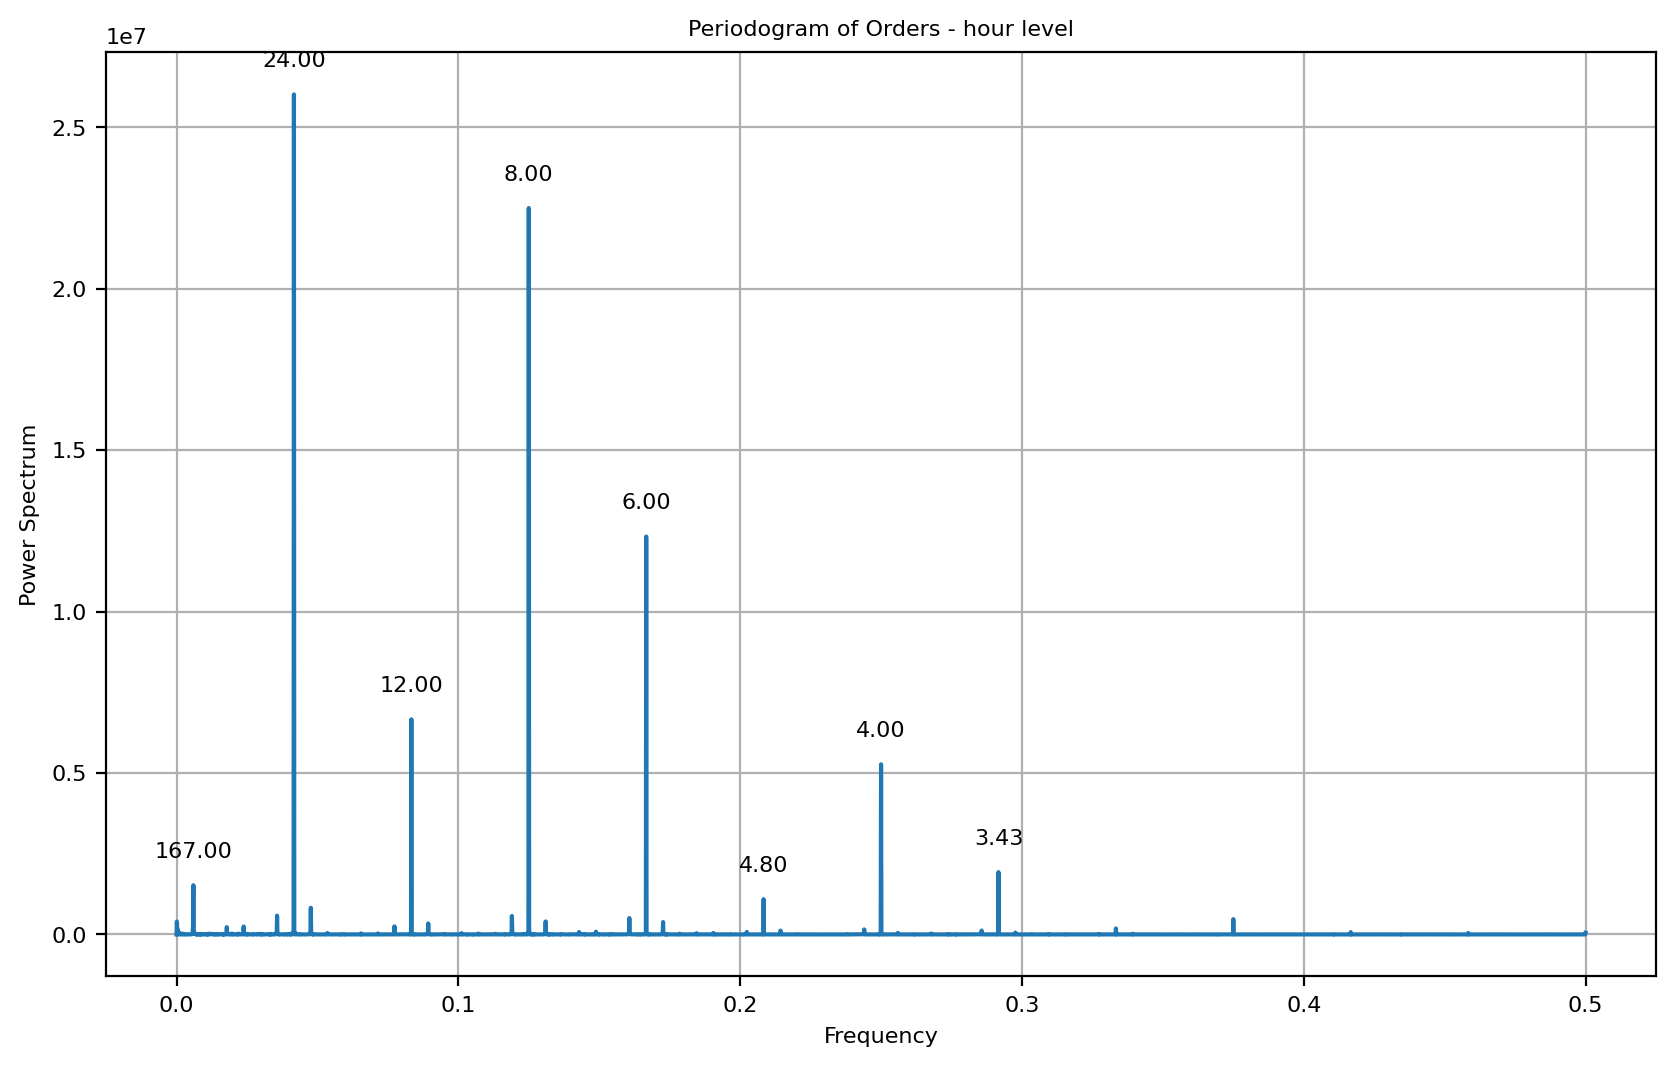

In [18]:
#periodogram: 24 hour level

df_period = df_orders[['time','orders']].copy()

# Set 'time' column as index
df_period.set_index('time', inplace=True)

# Resample data to get hourly counts
hourly_orders = df_period.resample('H').sum()

# Compute periodogram
frequencies, power_spectrum = periodogram(hourly_orders['orders'])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(frequencies, power_spectrum)
plt.title('Periodogram of Orders - hour level')
plt.xlabel('Frequency')
plt.ylabel('Power Spectrum')
plt.grid(True)

# Annotate points where power spectrum > 0.2
for freq, power in zip(frequencies, power_spectrum):
    if power > 0.1*(1e7):
        freq_ = 1/freq
        plt.annotate(f'{freq_:.2f}', (freq, power), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()


- Day of month: seasonality? nope

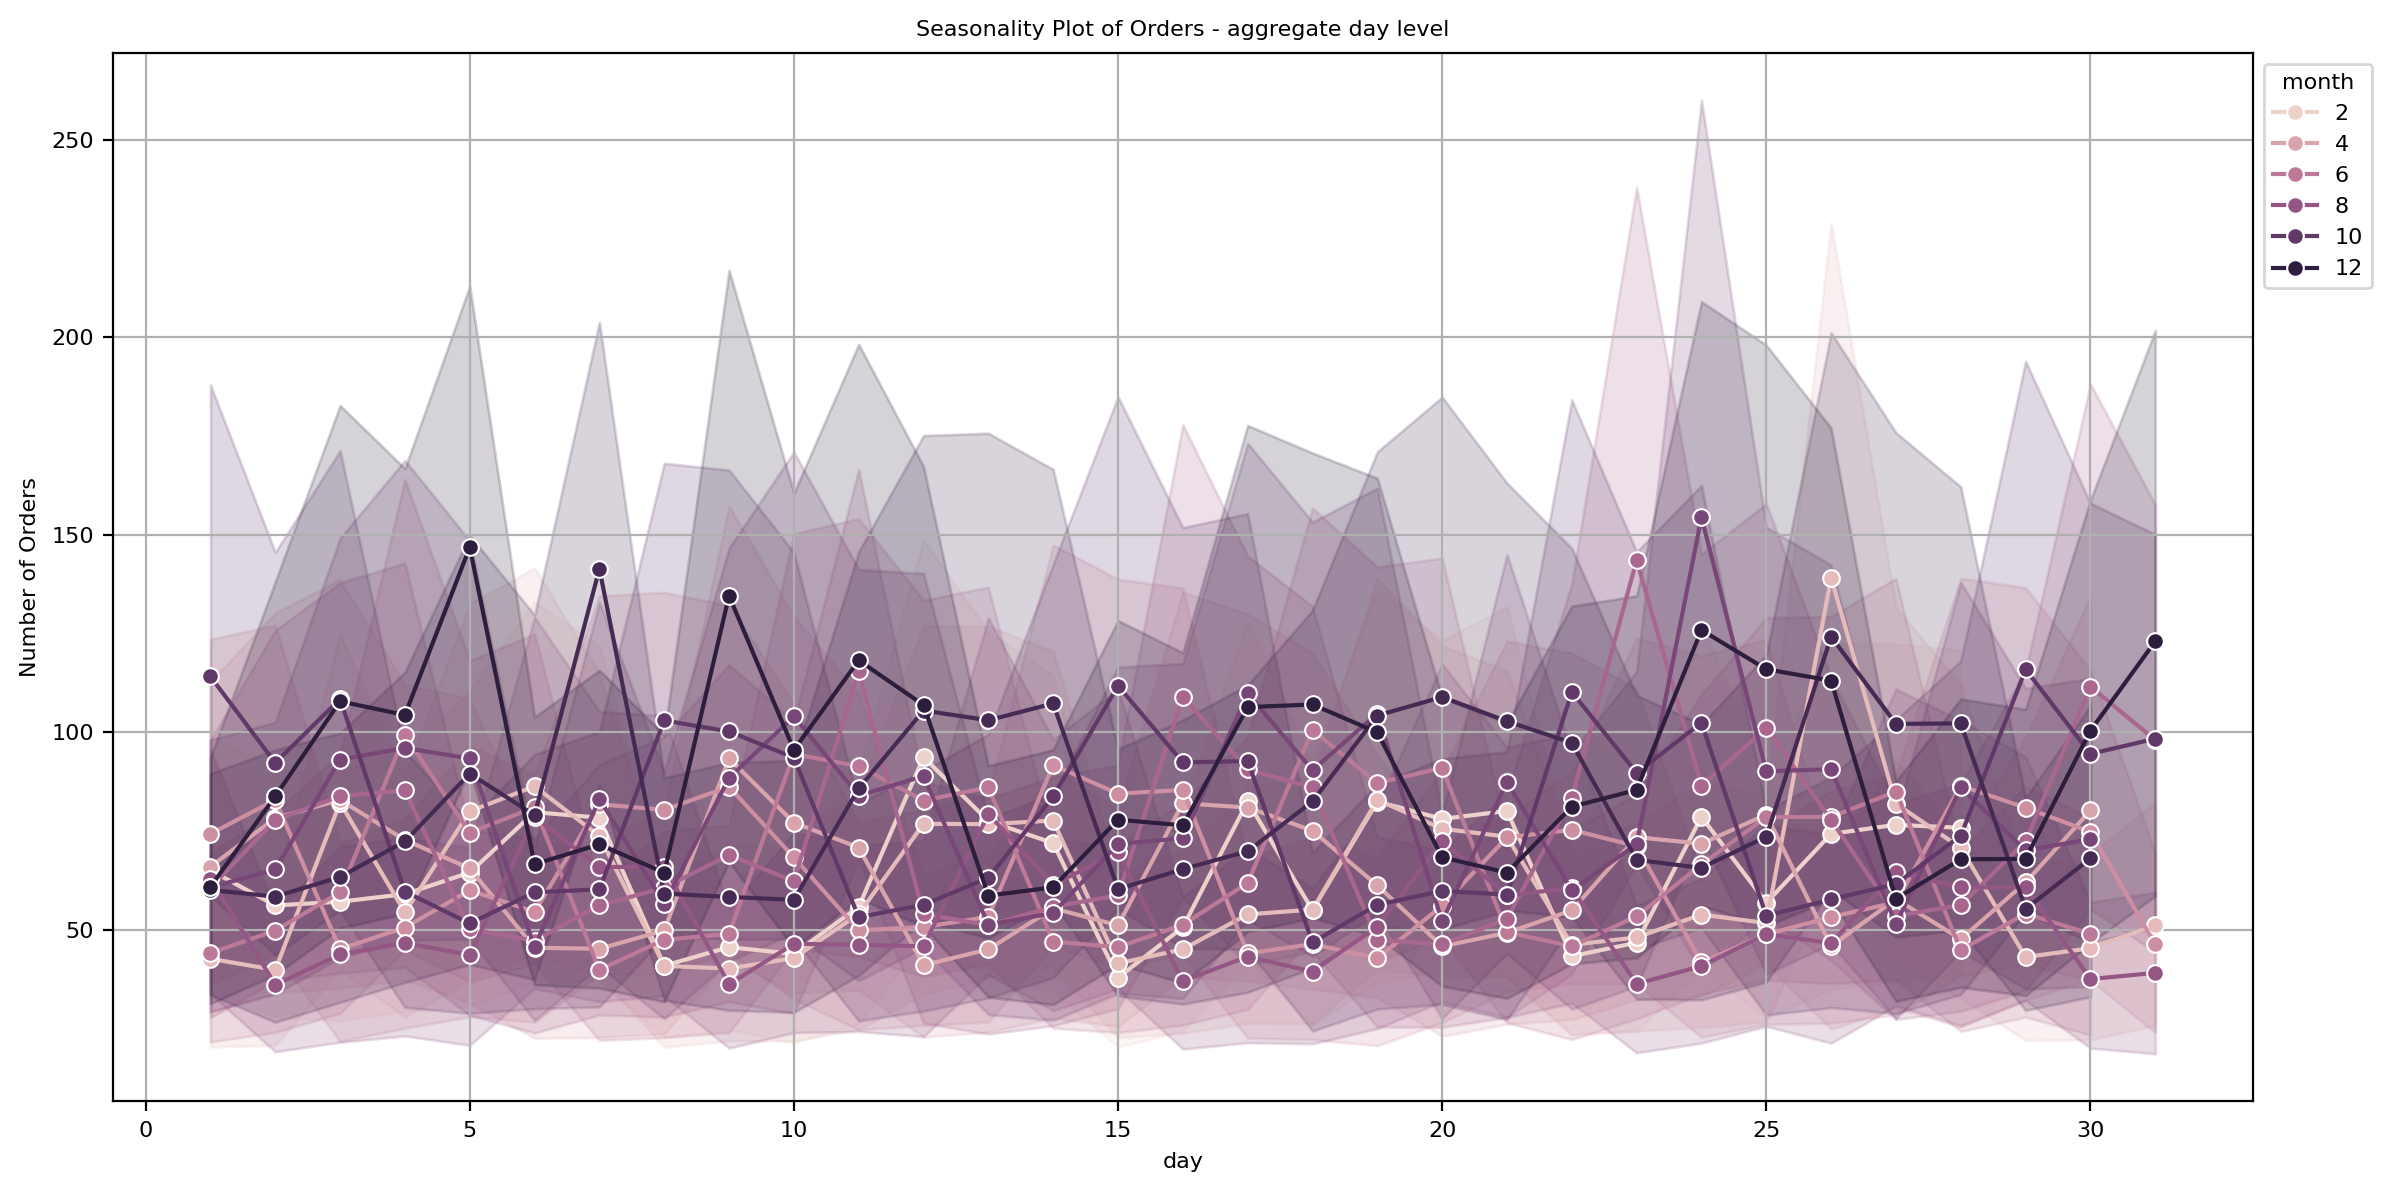

In [9]:
#line plot - day of month by month

df_period = df_orders.copy()
df_period['orders'] = df_period.groupby(by = ['date'])['orders'].transform('sum')
df_period.sort_values(by = ['date'], inplace = True)
df_period.drop_duplicates(subset = ['date'], inplace = True)

# Create a seasonal plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_orders, x='day', y='orders',hue = 'month', marker='o')

plt.title('Seasonality Plot of Orders - aggregate day level')
plt.xlabel('day')
plt.ylabel('Number of Orders')
plt.grid(True)
# plt.xticks(range())  # Set x-axis ticks to show every hour
plt.legend(title='month', loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside the plot
plt.tight_layout()
plt.show()

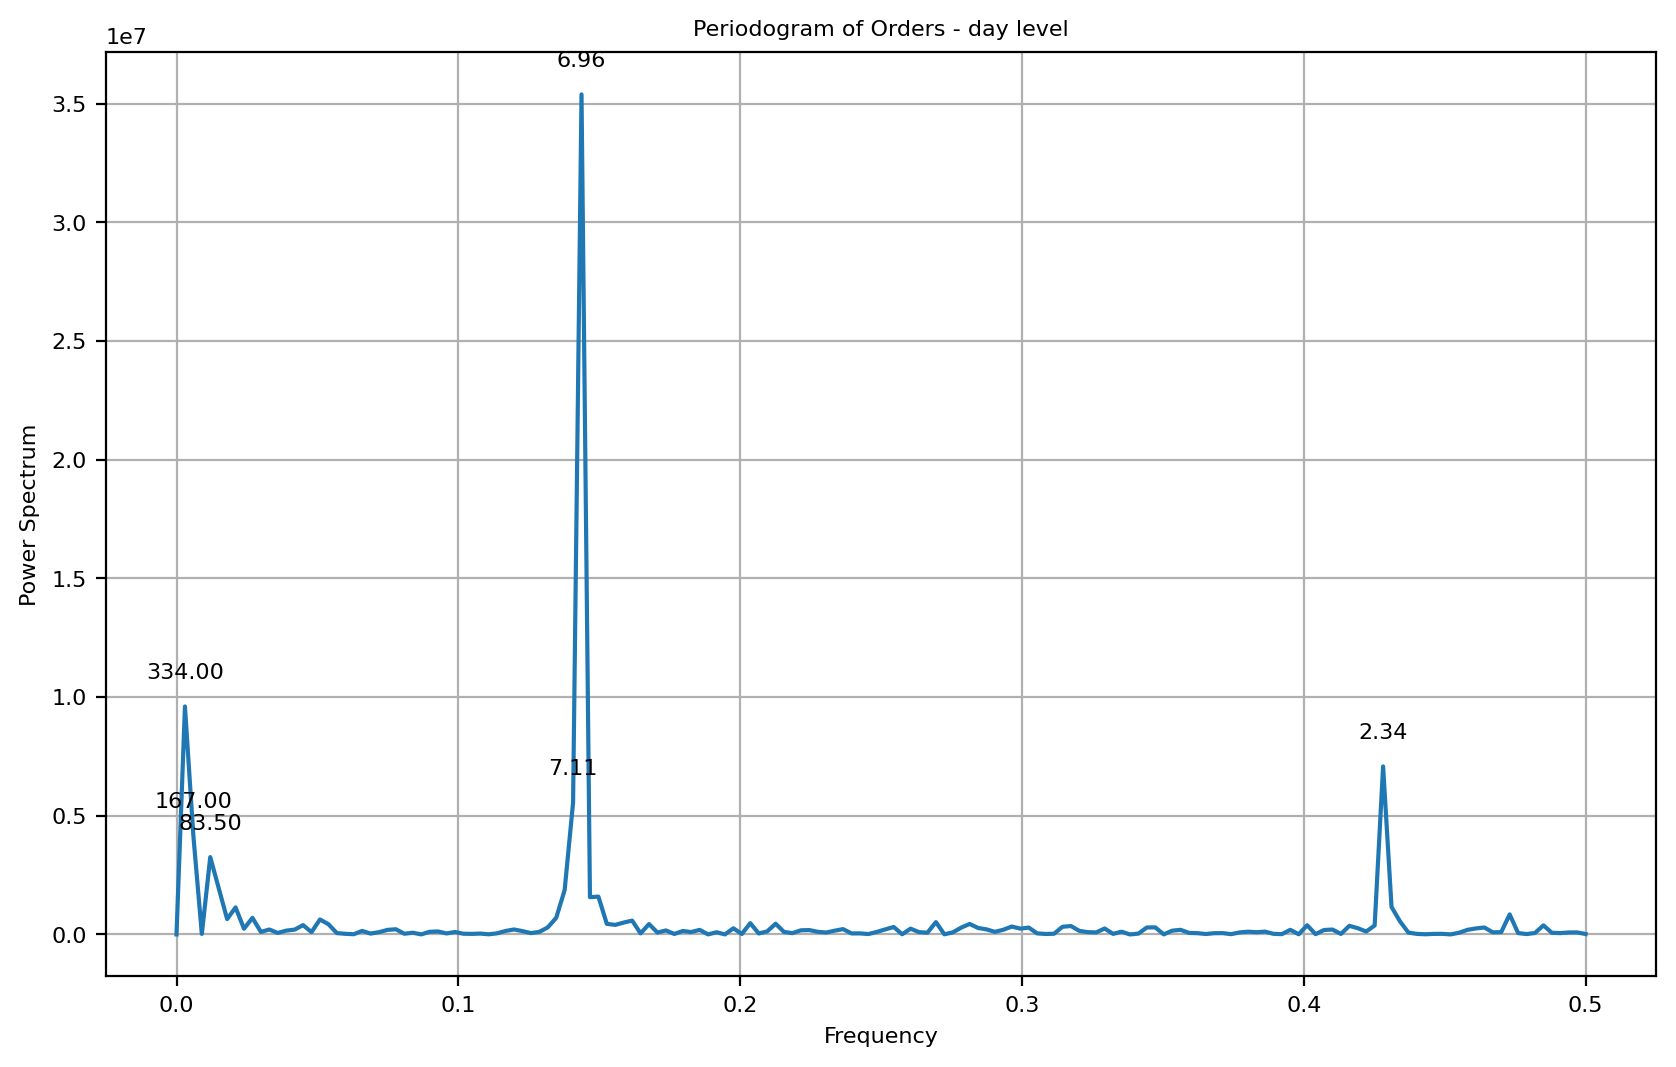

In [17]:
#periodogram: day within year

df_period = df_orders[['date','orders']].copy()
df_period['orders'] = df_period.groupby(by = ['date'])['orders'].transform('sum')
df_period = df_period[['date','orders']].drop_duplicates()

# Set 'time' column as index
df_period.set_index('date', inplace=True)

# Resample data to get hourly counts
hourly_orders = df_period.resample('D').sum()

# Compute periodogram
frequencies, power_spectrum = periodogram(hourly_orders['orders'])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(frequencies, power_spectrum)
plt.title('Periodogram of Orders - day level')
plt.xlabel('Frequency')
plt.ylabel('Power Spectrum')
plt.grid(True)

# Annotate points where power spectrum > 0.2
for freq, power in zip(frequencies, power_spectrum):
    if power > 0.25*(1e7):
        freq_ = 1/freq
        plt.annotate(f'{freq_:.2f}', (freq, power), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()


Doesn't appear to have seasonality by day in month. We're just seeing seasonality on week level and year level

- Month of year: seasonality? Not really a seasonality but maybe a cycle?

/tmp/ipykernel_94854/2695093799.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='aggregate month', loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside the plot


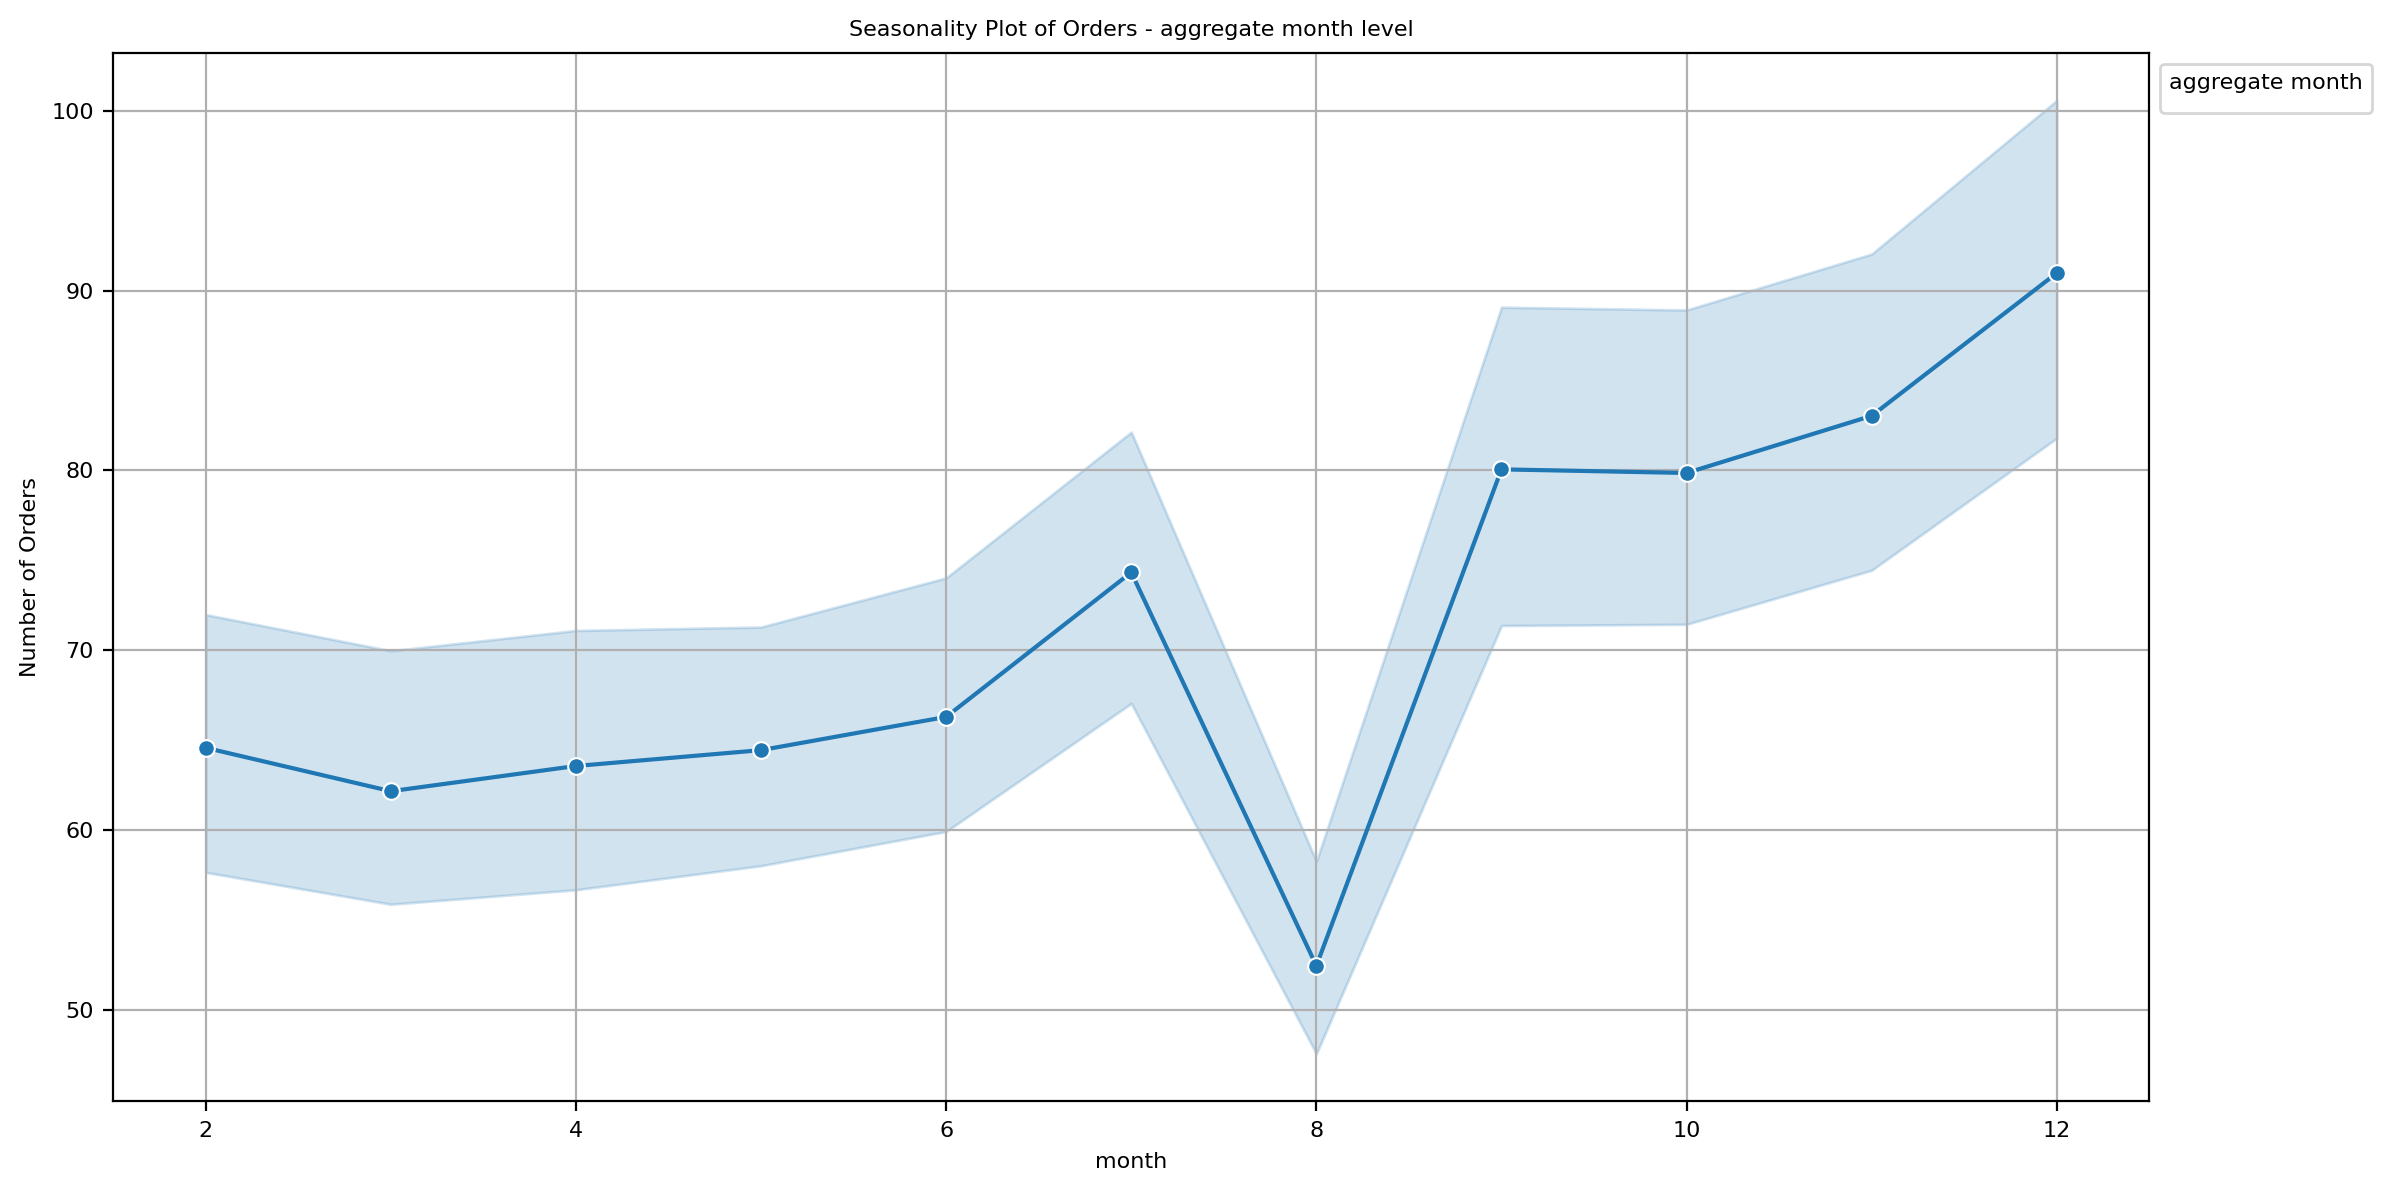

In [25]:
#line plot - month of year

df_period = df_orders.copy()
df_period['orders'] = df_period.groupby(by = ['month'])['orders'].transform('sum')
df_period.sort_values(by = ['date'], inplace = True)
df_period.drop_duplicates(subset = ['month'], inplace = True)

# Create a seasonal plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_orders, x='month', y='orders', marker='o')

plt.title('Seasonality Plot of Orders - aggregate month level')
plt.xlabel('month')
plt.ylabel('Number of Orders')
plt.grid(True)
# plt.xticks(range())  # Set x-axis ticks to show every hour
plt.legend(title='aggregate month', loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside the plot
plt.tight_layout()
plt.show()

/tmp/ipykernel_94854/3368026162.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  hourly_orders = df_period.resample('M').sum()


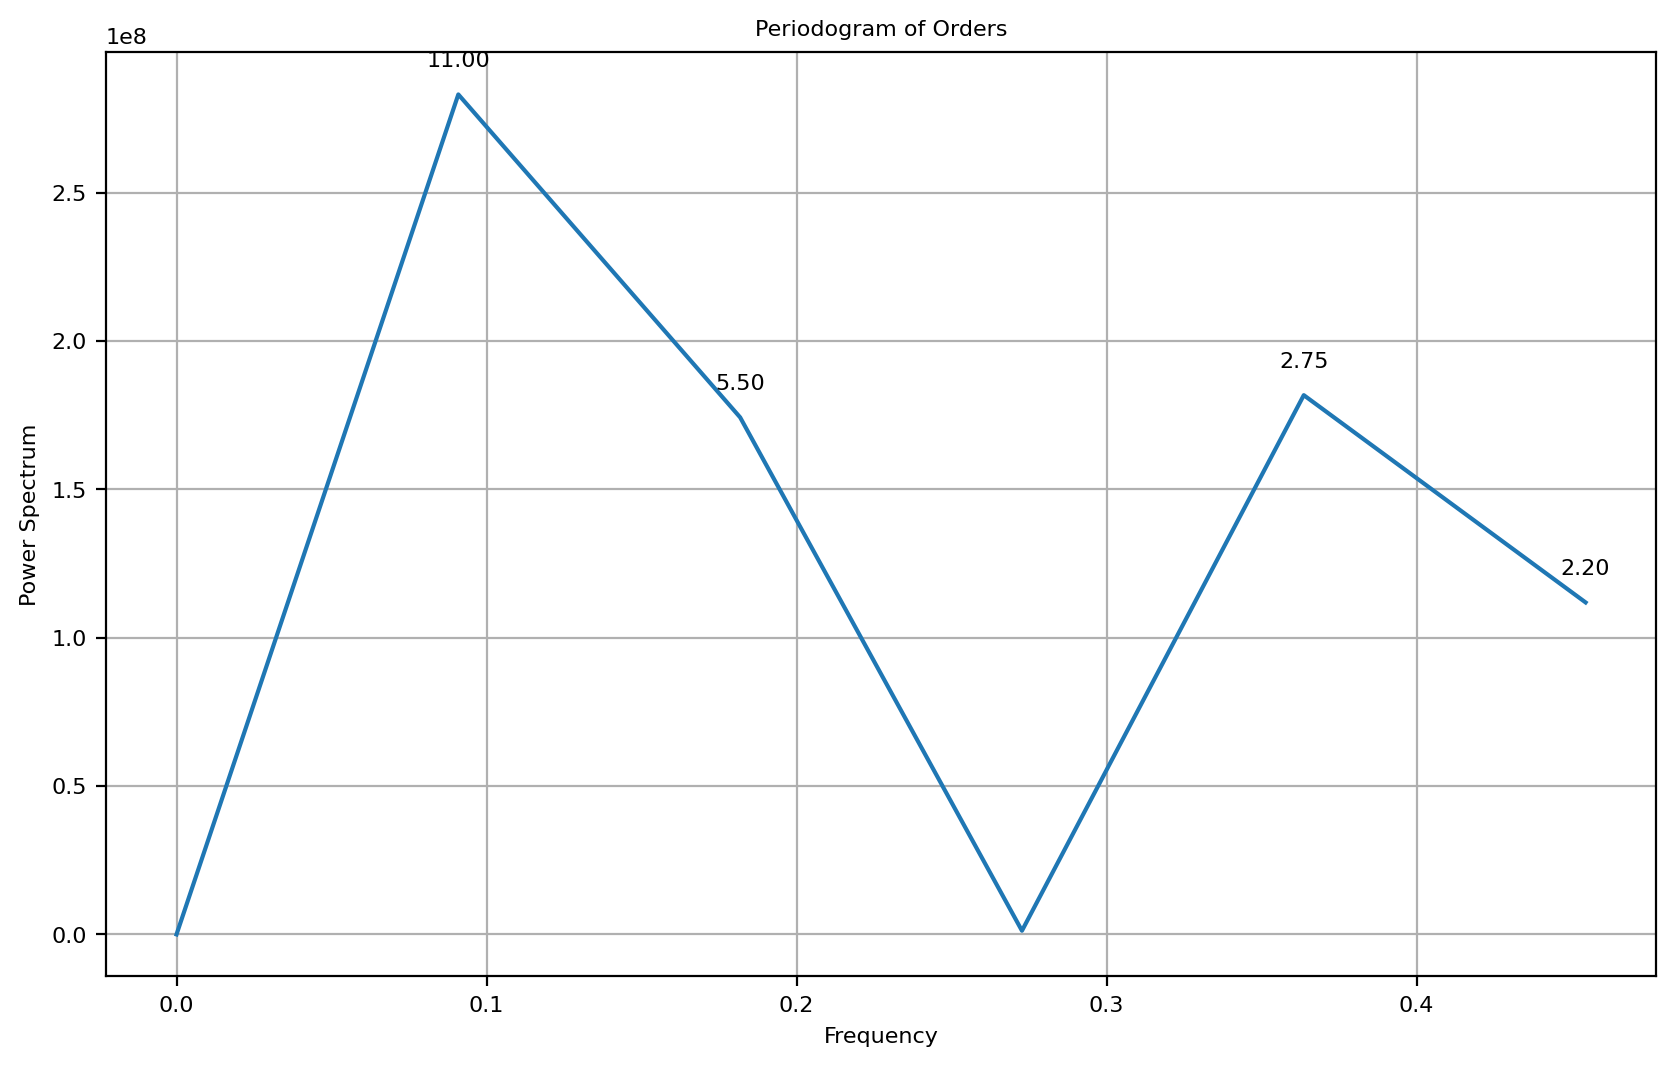

In [24]:
#periodogram - month of year

df_period = df_orders[['month','date','year','orders']].copy()
df_period['orders'] = df_period.groupby(by = ['month','year'])['orders'].transform('sum')
df_period.sort_values(by = ['date'], inplace= True)
df_period.drop_duplicates(subset = ['month','year'], inplace = True)
df_period = df_period[['date','orders']]

# Set 'time' column as index
df_period.set_index('date', inplace=True)

# Resample data to get hourly counts
hourly_orders = df_period.resample('M').sum()

# Compute periodogram
frequencies, power_spectrum = periodogram(hourly_orders['orders'])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(frequencies, power_spectrum)
plt.title('Periodogram of Orders')
plt.xlabel('Frequency')
plt.ylabel('Power Spectrum')
plt.grid(True)

# Annotate points where power spectrum > 0.2
for freq, power in zip(frequencies, power_spectrum):
    if power > 0.5*(1e8):
        freq_ = 1/freq
        plt.annotate(f'{freq_:.2f}', (freq, power), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

### Serial Dependence?
- 24 hour lag
- 168 hour lag
- otherwise not so much

lag_24
[[0.8908058]]
[7.89991526]


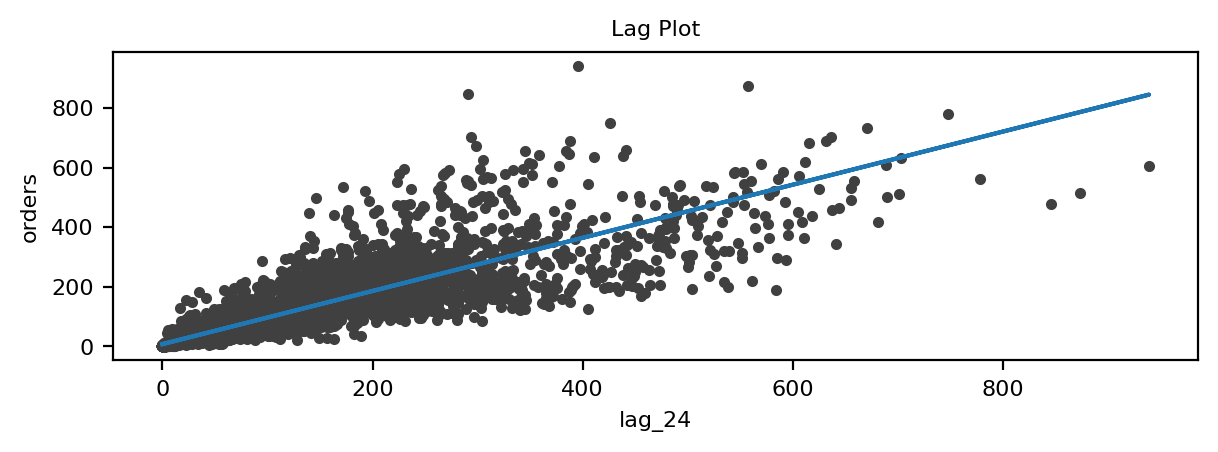

In [28]:
#lag plot - 24 hour lag (day previous)

lag_var = 'lag_24'

X = df_orders[['time','orders']].copy()

for i in range(1,32):
    X['lag_'+str(i)] = X['orders'].shift(i)
i = 48
X['lag_'+str(i)] = X['orders'].shift(i)
i = 168
X['lag_'+str(i)] = X['orders'].shift(i)
i = 167
X['lag_'+str(i)] = X['orders'].shift(i)
i = 169
X['lag_'+str(i)] = X['orders'].shift(i)
X.dropna(inplace = True)
X.set_index('time',inplace = True)
y = X[[TARGET]]  # the target
X.drop(columns = ['orders'], inplace = True)

X = X[[lag_var]]

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression()
model.fit(X, y)

print(lag_var)
print(model.coef_)
print(model.intercept_)

y_pred = pd.Series(model.predict(X).flatten(), index=X.index)

fig, ax = plt.subplots()
ax.plot(X[lag_var].values, y.values, '.', color='0.25')
ax.plot(X[lag_var].values, y_pred.values)
ax.set_ylabel('orders')
ax.set_xlabel(lag_var)
ax.set_title('Lag Plot');

lag_168
[[0.95922372]]
[3.4505404]


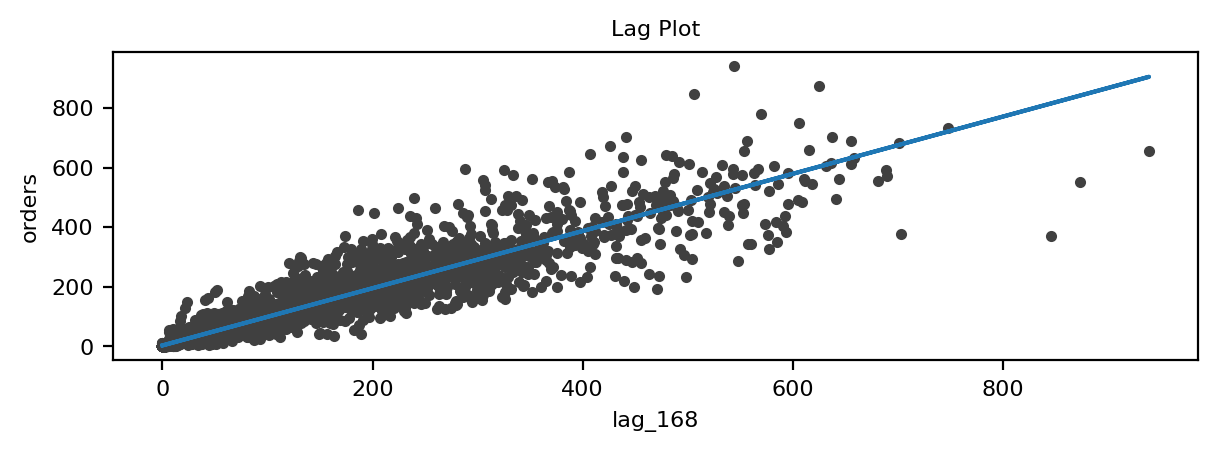

In [27]:
#lag plot - 168 hour lag (week previous)

lag_var = 'lag_168'

X = df_orders[['time','orders']].copy()

for i in range(1,32):
    X['lag_'+str(i)] = X['orders'].shift(i)
i = 48
X['lag_'+str(i)] = X['orders'].shift(i)
i = 168
X['lag_'+str(i)] = X['orders'].shift(i)
i = 167
X['lag_'+str(i)] = X['orders'].shift(i)
i = 169
X['lag_'+str(i)] = X['orders'].shift(i)
X.dropna(inplace = True)
X.set_index('time',inplace = True)
y = X[[TARGET]]  # the target
X.drop(columns = ['orders'], inplace = True)

X = X[[lag_var]]

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression()
model.fit(X, y)

print(lag_var)
print(model.coef_)
print(model.intercept_)

y_pred = pd.Series(model.predict(X).flatten(), index=X.index)

fig, ax = plt.subplots()
ax.plot(X[lag_var].values, y.values, '.', color='0.25')
ax.plot(X[lag_var].values, y_pred.values)
ax.set_ylabel('orders')
ax.set_xlabel(lag_var)
ax.set_title('Lag Plot');

lag_336
[[0.96274393]]
[3.83165109]


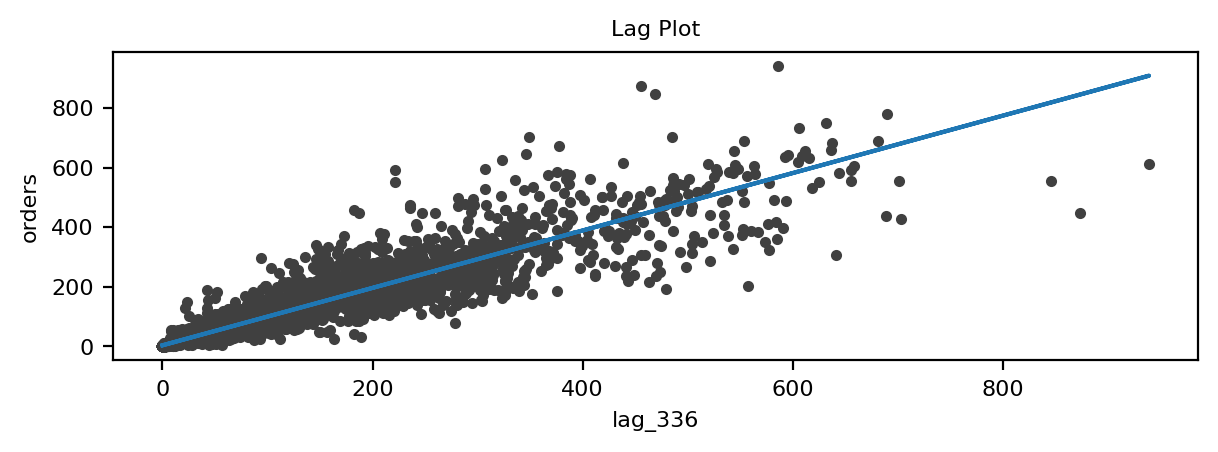

In [14]:
#lag plot - 168 hour lag (week previous)

lag_var = 'lag_336'

X = df_orders[['time','orders']].copy()

for i in range(1,32):
    X['lag_'+str(i)] = X['orders'].shift(i)
i = 48
X['lag_'+str(i)] = X['orders'].shift(i)
i = 168
X['lag_'+str(i)] = X['orders'].shift(i)
i = 167
X['lag_'+str(i)] = X['orders'].shift(i)
i = 169
X['lag_'+str(i)] = X['orders'].shift(i)
i = 336
X['lag_'+str(i)] = X['orders'].shift(i)
X.dropna(inplace = True)
X.set_index('time',inplace = True)
y = X[[TARGET]]  # the target
X.drop(columns = ['orders'], inplace = True)

X = X[[lag_var]]

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression()
model.fit(X, y)

print(lag_var)
print(model.coef_)
print(model.intercept_)

y_pred = pd.Series(model.predict(X).flatten(), index=X.index)

fig, ax = plt.subplots()
ax.plot(X[lag_var].values, y.values, '.', color='0.25')
ax.plot(X[lag_var].values, y_pred.values)
ax.set_ylabel('orders')
ax.set_xlabel(lag_var)
ax.set_title('Lag Plot');

### Features for linear regression

- Trend: not going to include because didn't really see strong trend data given by median
- Seasonality: 24 hour - fourier series, 168 hour - fourier series
- Lag: 168 (one week previous) lag inclusion, 336 (two week previous) lag inclusion

In [49]:
#functions to create features for linear regression

def create_features_train(df_in, col_include):
    df_ = df_in.copy()

    df_['lag_168'] = df_['orders'].shift(168)
    df_['lag_336'] = df_['orders'].shift(336)
    col_include.append('lag_168')
    col_include.append('lag_336')

    df_.dropna(inplace = True)
    df_.reset_index(drop = True, inplace = True)
    df_['dayofweek'] = df_['time'].dt.day_of_week
    df_['hour'] = df_['time'].dt.hour
    y_train = df_[TARGET].to_numpy()

    # #one hot encode hour of day
    # for hour in df_['hour'].unique().tolist():
    #     df_['ohe_hour_'+str(hour)] = 0
    #     df_.loc[df_['hour']==hour, 'ohe_hour_'+str(hour)] = 1
    #     col_include.append('ohe_hour_'+str(hour))

    #one hot encode day of week
    for day in df_['dayofweek'].unique().tolist():
        df_['ohe_'+str(day)] = 0
        df_.loc[df_['dayofweek']==day, 'ohe_'+str(day)] = 1
        col_include.append('ohe_'+str(day))

    t = df_['time'].to_numpy()
    df_.set_index('time', inplace = True)

    #24-hour level fourier series
    fourier = Fourier(period=24, order=12)
    X_24 = fourier.in_sample(t)

    #week level fourier series
    fourier_168 = Fourier(period=168, order=60)
    X_168 = fourier_168.in_sample(t)

    df_train = pd.concat([X_24, X_168, df_[col_include]], axis=1)
    return df_train, y_train

def create_features_val(df_in, df_val_in):
    df_val = df_val_in.copy()
    df_in = df_orders.copy()
    y_val = df_val['orders'].to_numpy()
    df_in['val'] = 0
    df_val['val'] = 1
    df_in = df_in[['time','orders','val']]
    df_val = df_val[['time','orders','val']]
    df_ = pd.concat([df_in, df_val], ignore_index = True)

    df_train, y_train = create_features_train(df_, ['val'])
    df_val_out = df_train[df_train['val']==1].copy()
    df_val_out.drop(columns = ['val'], inplace = True)
    return df_val_out, y_val


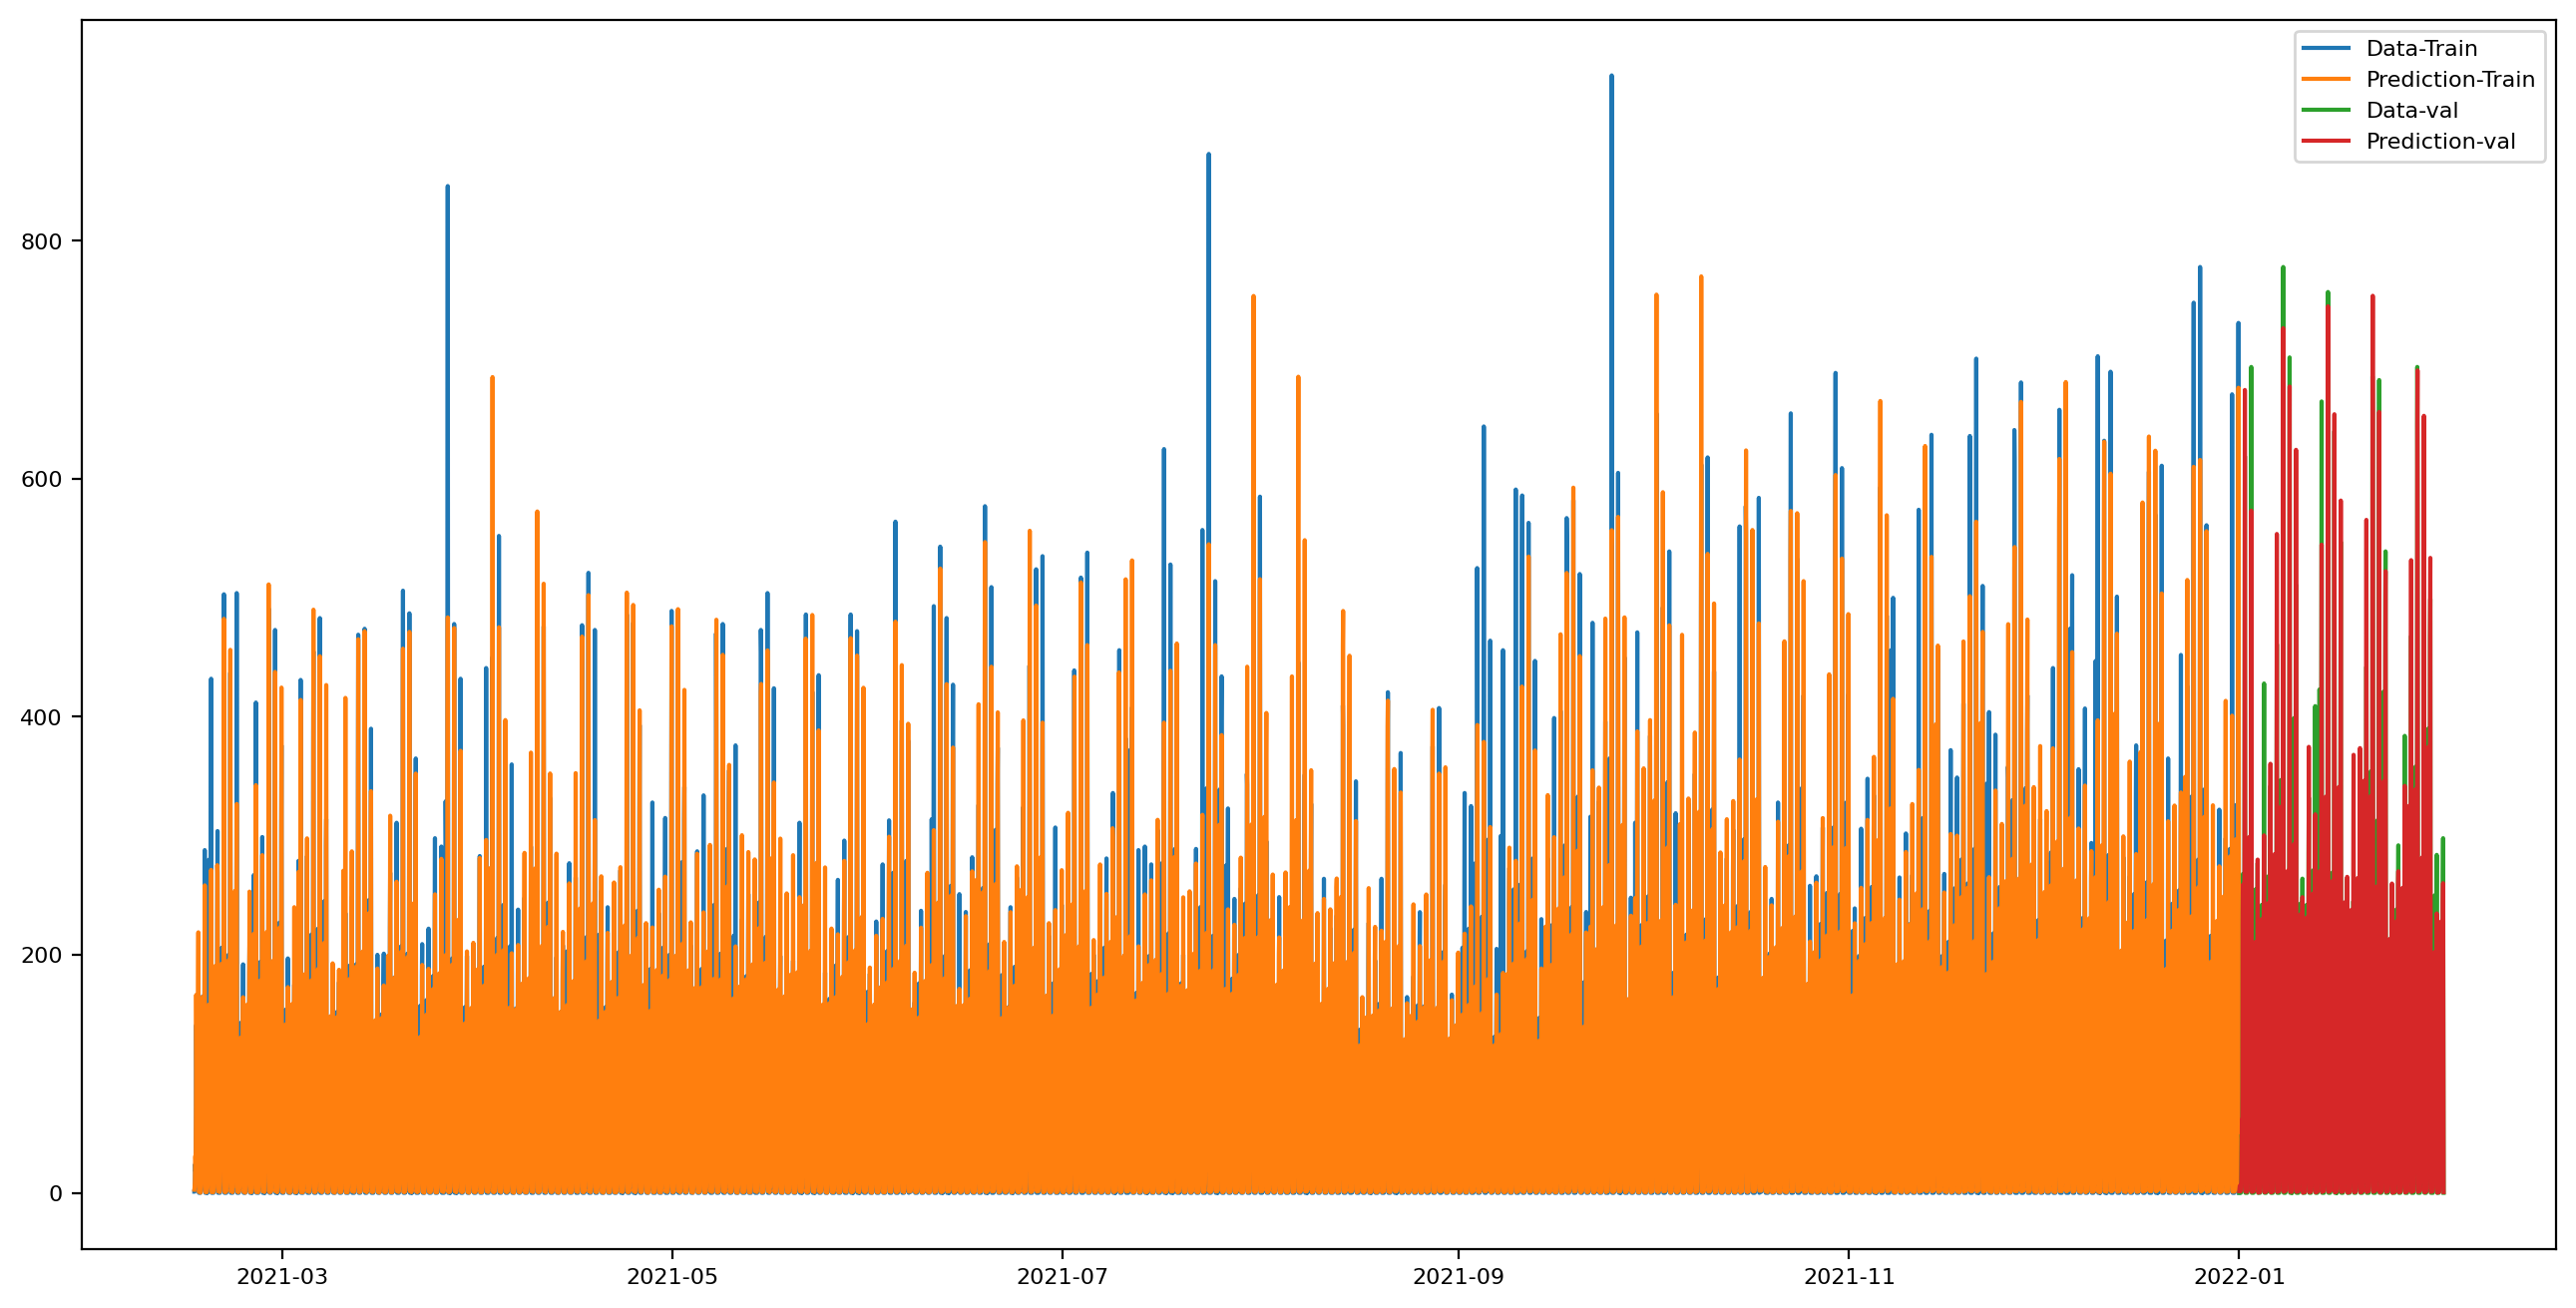

In [50]:
#Train and predict

X_train, y_train = create_features_train(df_orders, [])
X_val, y_val = create_features_val(df_orders, df_val)

X_val = X_val[X_train.columns]

t = X_train.index
# model = LinearRegression()
model = Lasso(alpha=0.1)
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)

t_val = X_val.index
y_pred_val = model.predict(X_val)

# Plot
plt.figure(figsize=(16, 8))
plt.plot(t, y_train, label='Data-Train')
plt.plot(t, y_pred_train, label='Prediction-Train')
plt.plot(t_val, y_val, label='Data-val')
plt.plot(t_val, y_pred_val, label='Prediction-val')
plt.legend()
plt.show()


In [54]:
#look at feature importance

df_features = pd.DataFrame({
    'feature': X_train.columns,
    'coeff': model.coef_
})

df_features['importance'] = df_features['coeff'].abs()/df_features['coeff'].abs().max()
df_features.sort_values(by = ['importance'], ascending = False, inplace = True)
print(df_features)

         feature     coeff  importance
7      cos(4,24) -1.403053    1.000000
0      sin(1,24)  0.831742    0.592809
6      sin(4,24)  0.831553    0.592674
4      sin(3,24)  0.795103    0.566695
24    sin(1,168) -0.558337    0.397944
..           ...       ...         ...
62   sin(20,168)  0.000000    0.000000
61   cos(19,168) -0.000000    0.000000
60   sin(19,168)  0.000000    0.000000
57   cos(17,168) -0.000000    0.000000
152        ohe_6  0.000000    0.000000

[153 rows x 3 columns]


- Performance Metrics

In [46]:
#performance metrics - MAE, MSE, RMSE, R-sqrd

#subset to only predict a week out
df_val_pred = pd.concat([pd.DataFrame(y_val, columns = ['orders']),pd.DataFrame(y_pred_val, columns = ['predictions'])], axis = 1)
df_val_pred.reset_index(inplace = True)
df_val_pred = df_val_pred[df_val_pred['index']<168]

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(df_val_pred['orders'], df_val_pred['predictions'])
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(df_val_pred['orders'], df_val_pred['predictions'])
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R²)
r2 = r2_score(df_val_pred['orders'], df_val_pred['predictions'])
print("R-squared (R²):", r2)


Mean Absolute Error (MAE): 13.650258983918325
Mean Squared Error (MSE): 662.882526351419
Root Mean Squared Error (RMSE): 25.746505128879512
R-squared (R²): 0.9662246001627094


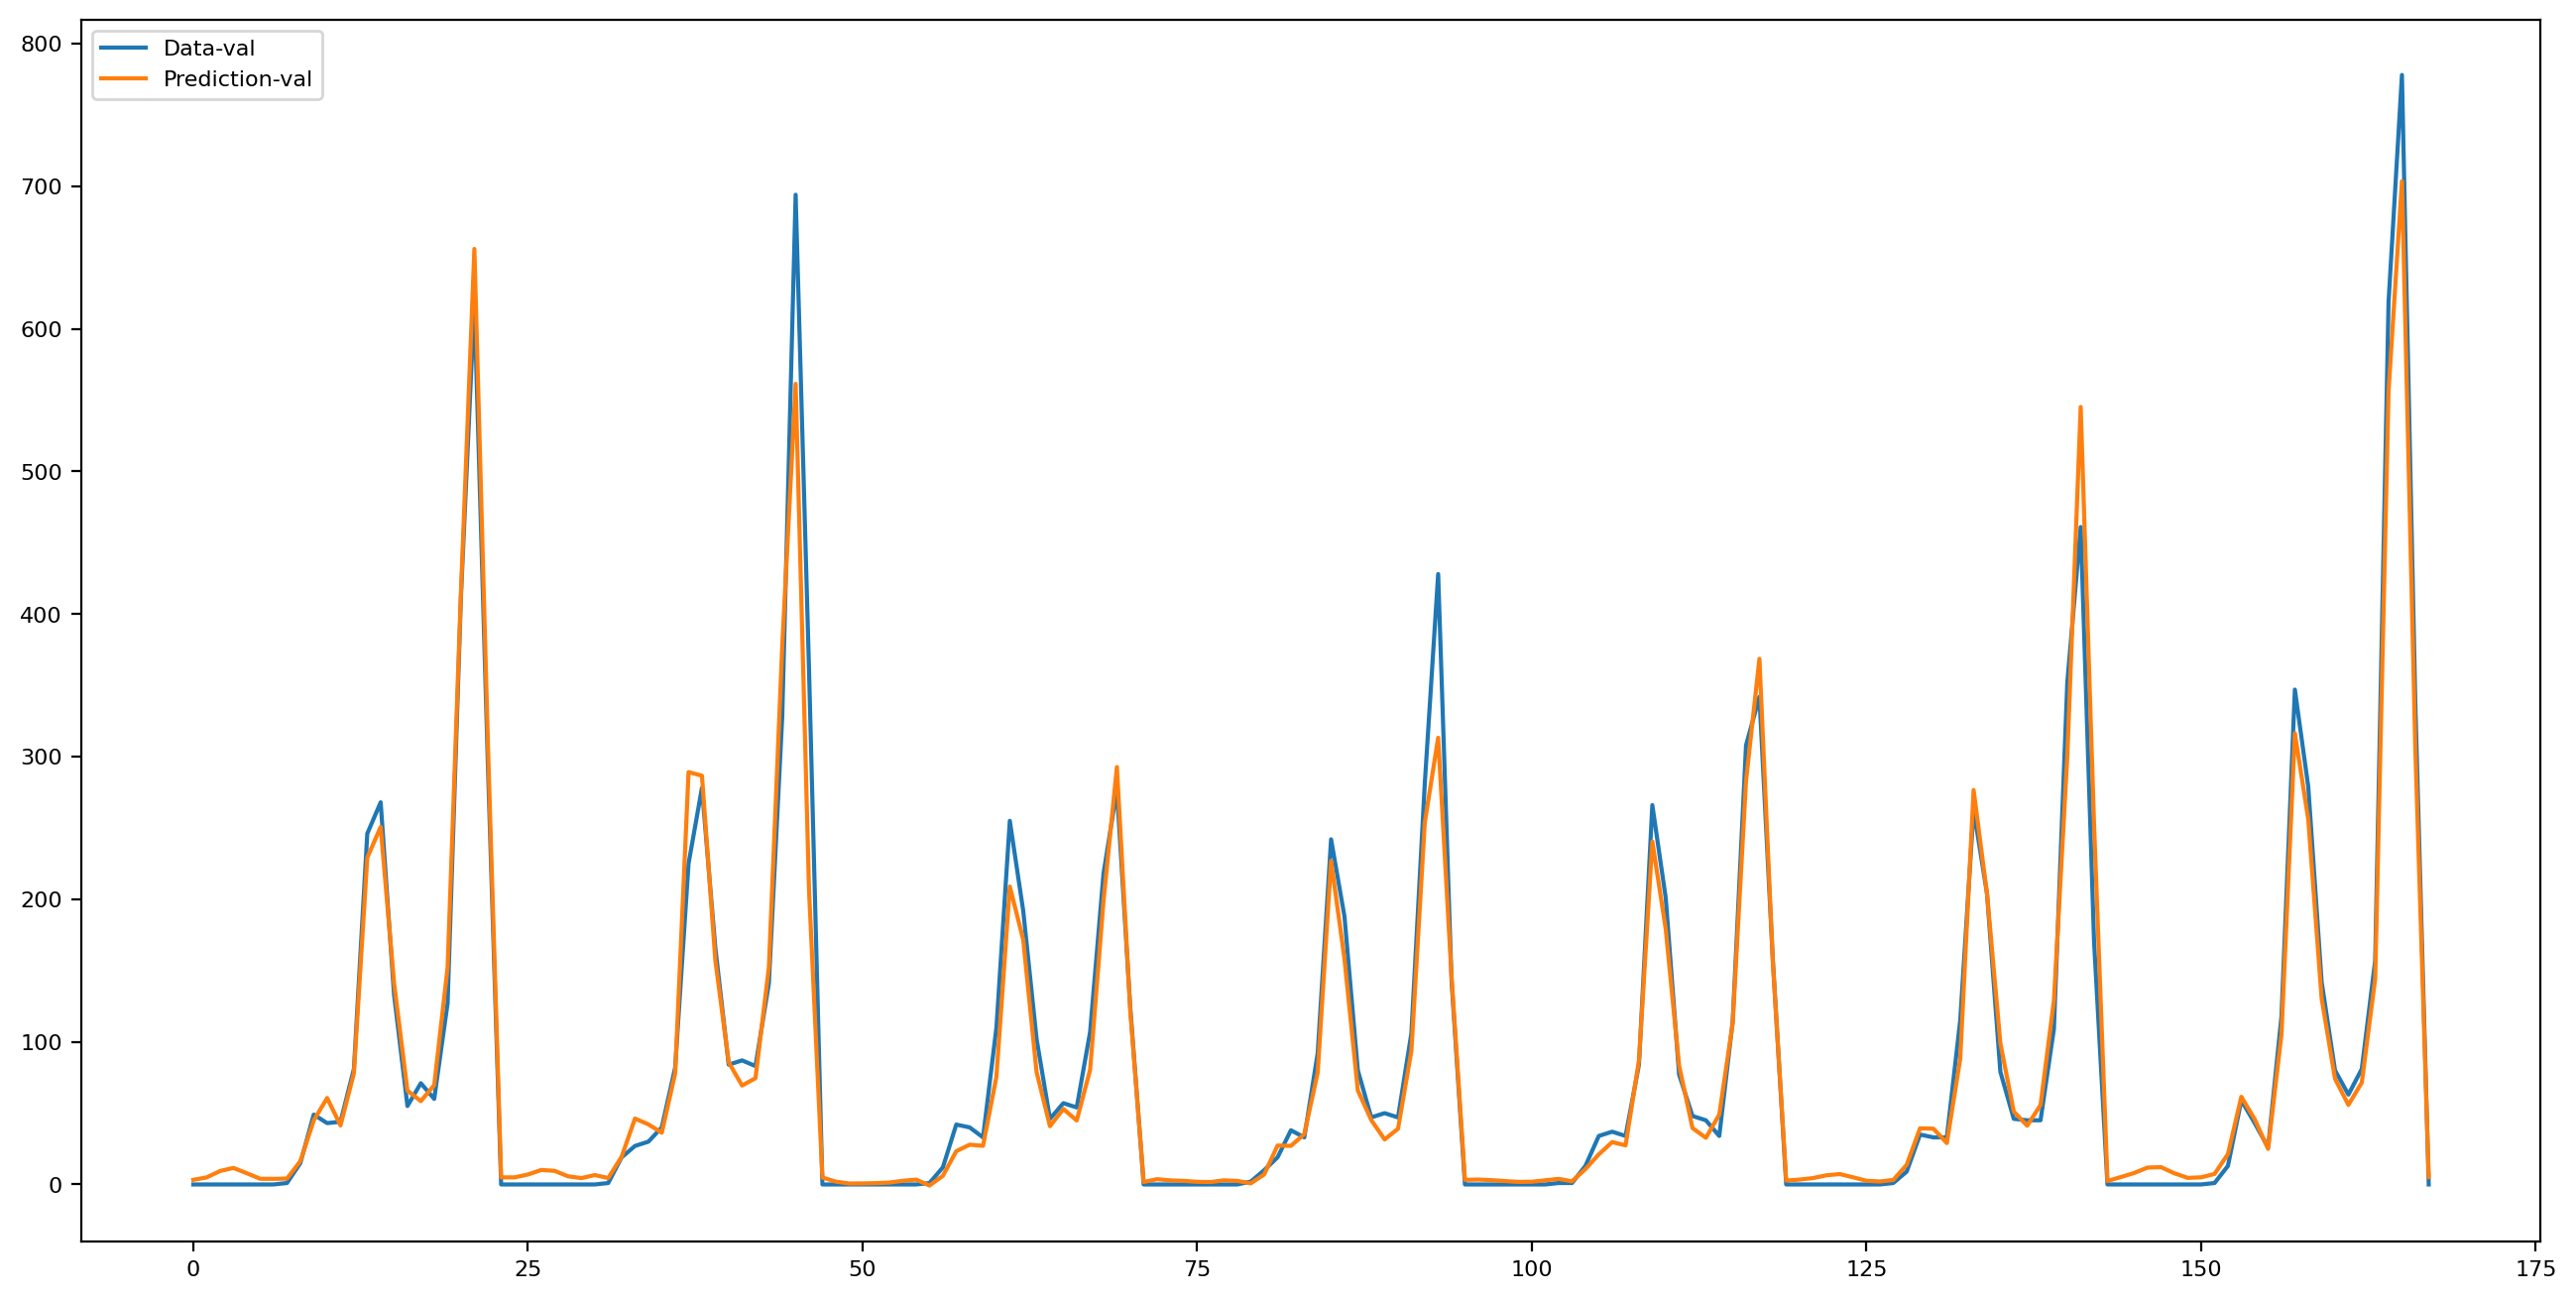

In [47]:
# Plot
plt.figure(figsize=(16, 8))
plt.plot(df_val_pred.index, df_val_pred['orders'], label='Data-val')
plt.plot(df_val_pred.index, df_val_pred['predictions'], label='Prediction-val')
plt.legend()
plt.show()
